# Executive Summary

Two analyses I've read of Dream's recent speedrunning performance have been flawed. I believe I can do better, and so I've done my own analysis. I point out a number of flaws with the two existing analysis, the most notable of which are the Minecraft Speedrunning Team's reliance on p-values and Photoexcitation's failure to mention that Bayesian methods are inherently less likely to conclude Dream cheated. I walk through the logic and mathematics behind my approach, which relies heavily on Bayesian statistics and conjugate priors. I implement said math in two Python routines, which allows anyone to easily run their own analysis, and put them to use with a more rigorous analysis of Dream's performance than is in either report. This analysis is easily reproducible and can be applied outside of Minecraft speedrunning.

Overall, I find the probability of Dream cheating to be much lower than the Minecraft Speedruning Team's report, at least five orders of magnitude lower in fact. Nonetheless, I also find his performance to be more consistent with simulated players who modified their version of Minecraft than with simulated players who did not or with comparable real-world Minecraft speedrunners. I do not make a definitive conclusion, in deference to the Minecraft speedrunning community.

I also point out an apparent oversight in the speedrunning community which could allow for different styles of cheating that are tougher to detect than usual. I also outline how to detect them, of course.

# Introduction

## Motivation

I first became aware of the accusations against Dream via [a blog I follow](https://statmodeling.stat.columbia.edu/2020/12/24/dream-investigation-results-official-report-by-the-minecraft-speedrunning-team/). As someone who has watched some of Dream's video content and is casually addicted to Minecraft, I was drawn to read the Minecraft Speedrunning Team's [report](https://mcspeedrun.com/dream.pdf). It is very well written, in my opinion, and the team behind it has put a lot of time and effort into creating a thorough investigation. Nonetheless, it made several assumptions I do not think are warranted, assumptions that create fundamental problems with the analysis it presented.

That same blog post pointed me towards a [rebuttal report](https://drive.google.com/file/d/1yfLURFdDhMfrvI2cFMdYM8f_M_IRoAlM/view), which had been declared "[hilariously bad](https://statmodeling.stat.columbia.edu/2020/12/24/dream-investigation-results-official-report-by-the-minecraft-speedrunning-team/#comment-1622865)" and riddled with "[absurd errors](https://www.reddit.com/r/statistics/comments/kiqosv/d_accused_minecraft_speedrunner_who_was_caught/ggse2er/?utm_source=reddit&utm_medtook%20time%20to%20review%20theium=web2x&context=3)." My primary critiques of the MST's report were not present, surprisingly, which drew me to read the rebuttal. It also made some faulty assumptions, and again some of what I considered to be the most important ones were missed by the critiques. While not perfect by any means, it was better than I was led to believe.

I asked myself if I could create a better report. After some thought, I realized the analysis was quite similar to others I've done in the past, and so I started work on what you are currently reading.

## Declaration of Bias

I am a graduate student in computer science, specializing in computer graphics. I have not taken a university-level statistics course, though I have taken two courses on cryptography and information theory, and those subjects rely heavily on probability. Neither taught me anything new about probability; my interest in algorithms and philosophy have led me to casually study the statistics underlying science. I've found that self-study to be of immense use, as all my research has relied on statistical analysis at some level. At best, I can be considered an amateur statistician.

My plan to compensate for my lack of authority is to be more detailed and open. I will walk through all the math I employ, and explain my analysis and logic as I go. Not only is all the code I used available [via GitHub](https://github.com/hjhornbeck/bayes_speedrun_cheating/) under the [GNU Public License 3.0](https://github.com/hjhornbeck/bayes_speedrun_cheating/blob/main/LICENSE), it is present in this document as well. You can edit and replay both the simulations and analysis [via a web browser](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb), with the click of this button:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hjhornbeck/bayes_speedrun_cheating/blob/main/did_dream_cheat.ipynb)

Clicking that button won't be enough to transfer the necessary data files over. There are two cells with code that might retrieve that data for you once uncommented. Otherwise, you will need to manually copy over the data files into a directory called "data". Those files are availble [here](https://github.com/hjhornbeck/bayes_speedrun_cheating/tree/main/data).

**I have not been paid by Dream to write this report, directly or indirectly. I have not been contacted by him or any third party, let alone asked to write this report.** I have enjoyed watching some of his videos, and I believe he is a very talented Minecraft player, but I am indifferent to whether or not his speed runs are considered valid.

**By the same token, I have no relationship with the Minecraft speedrunning community. None of them have contacted or paid me to write this report, directly or via a third party.** I have no plans on becoming a Minecraft speed runner, I'm content to merely build things and do some casual streaming.

My motivations for writing this report can be boiled down to two points:

1. [I hate p-values](https://www.google.com/search?q=p-values+site%3Afreethoughtblogs.com%2Freprobate).
2. [I enjoy working with conjugate priors](https://freethoughtblogs.com/reprobate/2020/02/19/dear-bob-carpenter/).

As you'll see, that gives me enough knowledge to critique both reports and generate my own analysis.

# A Critique of the Reports

## Minecraft Speedrunning Team

The [MST report](https://mcspeedrun.com/dream.pdf) is quite good. The authors go into extensive detail on the mechanics of how Blaze rod and Pigmen drops work, to the point of analyzing how random numbers are generated within Minecraft. They compare Dream's performance to other runners, which is vital to help rule out flaws in your analysis. If the analysis shows *all* of the top players are cheating, then either cheating is rampant or something is wrong with your analysis. The report goes into quite a bit of detail into the methods used, and shares code to help with reproducibility. I believe it is a good attempt to "present \[an\] unbiased, rigorous statistical analysis of the data" (pg. 4).

The biggest flaw with the report is the reliance on p-values to generate its conclusions. I have summarized [many critiques of that statistic elsewhere](https://freethoughtblogs.com/reprobate/2015/12/17/index-post-p-values/), but two points are worth covering here.

### P-values are Not What You Think

This is the definition of the p-value:

> If we assume the null hypothesis is true, and draw an infinite amount of data according to what that hypothesis predicts, how often is the test metric applied to that data calculated to be equal to or more extreme than the test metric calculated on the data we observed?

On its surface, it's a very strange metric. Why are we basing our decision on data we have not and will never observe? What counts as "extreme"? The core logic relies on both [modus tollens](https://mathworld.wolfram.com/ModusTollens.html)\footnote{If A is true, B is true; B is false; ergo A is false.} and [the central limit theorem](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Probability/BS704_Probability12.html)\footnote{The means of sufficiently large samples taken from a larger population will follow a Gaussian distribution centred at the population mean.}, which are usually correct but not always so.\cite{cohen_earth_1994,vanderplas_frequentism_2014} 

P-values are not a probability of the null hypothesis being incorrect and cannot be treated as such, yet the MST report declares their final p-value to be an "upper bound on the chance" of Dream getting that lucky (pg. 22). The text which popularized the p-value encourages this mistake.

> When a number of quite independent tests of significance have been made, it sometimes happens that although few or none can be claimed individually as significant, yet the aggregate gives an impression that the probabilities are on the whole lower than would often have been obtained by chance. It is sometimes desired, taking account only of these
probabilities, and not of the detailed composition of the data from which they are derived, which may be of very different kinds, to obtain a single test of the significance of the aggregate, based on the product of the probabilities individually observed. (pg. 103)\cite{fisher1934statistical}

It is often not clear that Sir Ronald Fisher is talking about the odds of calculating a test statistic more extreme than data generated according to the null hypothesis, rather than the odds of the null hypothesis being true. Few people understand the p-value, and even experts can misinterpret it.

> In a recent survey of medical residents published in JAMA, 88% expressed fair to complete confidence in interpreting P values, yet only 62% of these could answer an elementary P-value interpretation question correctly. However, it is not just those statistics that testify to the difficulty in interpreting P values. In an exquisite irony, none of the answers offered for the P-value question was correct $\dots$ \cite{goodman_dirty_2008}

### P-values Exaggerate the Evidence

Multiple studies have looked into the predictive power of p-values by simulating experiments.\cite{hubbard_why_2008,colquhoun2014investigation,halsey_fickle_2015} These should be taken with a grain of salt, as many of them argue p-values exaggerate the evidence relative to Bayesian methods. If you believe hypotheses can only be true or false, and cannot be assigned probability values, then you believe Bayesian methods are invalid and thus cannot be used as a reference. Not all of these simulation studies use that reference, however.

> In this article, I investigate p-values in relation to replication. My conclusion is that, if you repeat an experiment, you are likely to obtain a p-value quite different from the p in your original experiment. The p-value is actually a very unreliable measure, and it varies dramatically over replications, even with large sample sizes. Therefore, any p-value gives only very vague information about what is likely to happen on replication, and any single p-value could easily have been quite different, simply because of sampling variability.\cite{doi:10.1111/j.1745-6924.2008.00079.x}

The evidence has become strong enough that some researchers have proposed lowering the traditional p-value cut-off of 0.05 to a lower value.\cite{Johnson19313} The theory is that rather than asking scientists to abandon the use of p-values, it is simpler to compensate by lowering the threshold for significance and thus increasing the amount of evidence required to reach that bar. Some fields of science have already made that transition, for instance particle physics and genomics research often require $p < 0.0000003$. If p-values exaggerate the evidence against the null hypothesis, and the null hypothesis is that Dream's drop rate was unmodified, then by using p-values the MST report is exaggerating the evidence against Dream. This alone makes another report worthwhile.

I have other complaints about the MST report, but there's significant overlap between them and what's in the Photoexitation report.

## Photoexcitation

The PE report offers a few good critiques. It argues that since Minecraft speedrunners almost always stop after they've earned $k$ items, instead of stopping after $n$ barters/drops, the resulting $k$ and $n$ do not follow the binomial distribution. The MST report does not consider this argument in the context of items picked up, though it does consider it in the context of when a speedrunner stops playing.

The PE report's decision to use Bayesian statistics was correct, as in my opinion it copes better with small sample sizes than frequentist methods such as the p-value. It also used simulations to examine the relevant mechanics of Minecraft, a wise choice that makes it easier to examine different possible outcomes in a controlled environment.

### Overuse of the Negative Binomial

That simulation within the PE report does show a blind spot. First, consider Blaze rods. In order to earn them in Minecraft, you must kill Blazes. While it is possible to kill multiple Blazes at once, the only way that's practical during a speedrun is to use the sweeping edge attack of a sword against one Blaze with multiple other near-death Blazes nearby. On top of the difficulty of acheiving that feat, most Minecraft speedrunners never craft a sword. Axes do more damage per strike than a sword, are practically a requirement to gather vital wood, and yet the lack the ability to attack multiple mobs. Nearly always, then, Minecraft runners kill one Blaze at a time, and thus can easily stop when they meet their quota.

A key part of a random seed any \% Minecraft 1.16 speedrun is earning Ender pearls via bartering with Piglins. Unlike Blaze rods, which drop instantly after a Blaze dies, Piglins only give the player an item six seconds after the player gave them a gold bar. This, combined with the low chance of earning Ender pearls via a barter, creates a major time barrier for any speedrunner. Fortunately for the player, they don't have to manually hand over every gold bar and can instead drop a stack of them at the feet of the Piglin.

Runners can speed up this process one of two ways. For their 14 minute 39 second speed run, Couriway bartered [with a half-dozen Piglins simultaneously](https://youtu.be/0auJTuzm_Xc?t=404) and waited until they got enough Ender pearls. By bartering with so many Piglins, though, they no longer had strict control over when to stop and thus we'd expect a barter stats of runners using this technique to be more Binomial than Negative Binomial.

Another approach is to multitask. For their 15 minutes 51 second speedrun, Dowsky trapped a Piglin in a pit, tossed gold bars into it, and while the Piglin was bartering [ran off to kill Blazes](https://youtu.be/0auJTuzm_Xc?t=404). If the Blaze spawner is far enough away, the player won't be able to see when Ender pearls drop and thus won't be able to stop bartering once their quota is met. In this case the barters would be better modelled by a Binomial than a Negative Binomial.

The simulation code present on page 17 of the PE report, though, only models bartering with a single Piglin that the player can monitor closely. That would be perfectly fine if they could show Dream used that technique exclusively when bartering with Piglins, but the report makes no such effort.

### Misunderstanding Minecraft

The PE report demonstrates other misunderstandings about how Minecraft is played.

> If you consider every Minecraft player, then a ”perfect” ender pearl and blaze drop record (2/2 ender pearl barters and 7/7 blaze rod drops) occurs multiple times per hour, since this has a 1 in 60000 odds and Minecraft is played many millions of times a day. Considering all Minecraft worlds ever played and the multitude of ways in which luck plays a role, even one in a trillion events happen daily.

I am a Minecraft player. While I haven't tracked my Ender pearl barter stats, I can state with confidence that of the zero attempts I'm made to earn Blaze rods, zero have been successful. This is because I have no interest in reaching "The End" at the moment, nor have I had the inclination in the six months or so I've been playing this game. If that did change, I'm playing on a private server with other people who have long since tracked down a stronghold on our shared map and set up a minecart route to it. In practice, gathering the materials to make an Eye of Ender is something most Minecraft players rarely do, and when they attempt it is only rarely done more than once the entire time they play Minecraft. Only a very small fraction of the Minecraft community attempts to speedrun the game, and only those players routinely hunt for Ender pearls and Blaze rods. One in a trillion events can happen daily, but only if about a trillion attempts are made at those events per day.

This lack of knowledge is understandable, given the author does not appear to be a Minecraft player. Nonetheless, the more you know about a topic the more likely any analysis of that topic will rest on false premises.

### Lack of a Comparison to Real World Data

This premise leads the PE report to forgo comparisons to other speedrunners.

> Comparison to other runners is not necessary to establish that Dream had very low probability runs. Instead this comparison is more relevant to the interpretation of these low probabilities. For example, it reduces the plausibility that the low probabilities were due to some universal glitch that affects all speedrunners. As the reader is assessing the evidence, the low probability of Dream’s runs and that Dream performed much better than other speedrunners should not be considered as independent pieces of evidence as they both are consequences of the same thing. Any lucky speedrunner chosen because they look lucky will look lucky when compared to other speedrunner
streams that were chosen randomly.

At the core of statistics is the idea of [a reference class](https://en.wikipedia.org/wiki/Reference_class_problem). By invoking every Minecraft player, the PE report is stating that Dream's performance should be compared to them, or in other words that they are the appropriate class of entities to use as a reference. Here, though, the report argues that Dream's performance should not be compared to that of other top speed runners, because it is too dissimilar and therefore makes a poor reference class.

Setting aside the argument that this is the reverse of reality, it is notable that the report makes no attempt to compare Dream's performance to any real-world reference class. If a perfect Blaze rod and Ender pearl bartering session is indeed a common occurance, it should be easy to demonstrate that by pointing to a few examples of ordinary Minecraft players acheiving those feats. Even if they are rarely recorded, discussion of such events must appear in comment sections or Discord channel messages, and we would expect it to be common knowledge among players of Minecraft.

Conversely, even if other speedrunners are an inappropriate reference class, running their performance through the report's simulation would be a valuable check that it is working properly. This is why scientific studies usually have control groups, as they are a validation of the methodology. The author of this report had the data to do this, thanks to the MST report, and passing it through their simulation was as easy as editing two lines of code, so there was no lack of means or opportunity.

### Missing Context

> In this document, I don’t have time to discuss the long-term debate between these different statistical
paradigms and when they should be applied. The short version is that another way of investigating whether
the probabilities were modified is to try to determine what probabilities were used. (pg. 5)

By skipping the details, the PE report leaves out an important consequence of using Bayesian statistics. You can simplify Bayesian stats down to

> Given the data before me, what credence do I place on a hypothesis relative to some reference?

"Credence" can be thought of in terms of "belief points:" when I say I give 100:1 odds that Joe Biden will become President of the United States, I am saying that for every one belief point I give to the hypothesis "Joe Biden will not become President" I also give one hundred towards "Joe Biden will become president."\footnote{The comparison to betting odds is no accident, the study of statistics began with people trying to figure out either how to cheat at gambling or how to detect said cheating.\cite{doi:https://doi.org/10.1002/0471667196.ess0845.pub3}}

Mathematically, "credence" is the output of a [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function). Likelihoods obey all the same rules as probabilities, save one: while probabilities are bounded to stay between 0 and 1, likelihoods only have a lower bound of zero. The inputs to a likelihood function are the data we observe, as well as parameters used to describe a model of our belief in that data. These parameters form a multi-dimensional parameter space. All hypotheses we can make about the data live within that space. These may be point hypotheses ("Dream's Blaze rod drop rate was precisely 0.509583957"), or composite hypotheses that are a weighted subset of all possible point hypotheses ("Dream's Blaze rod drop rate ranged between 0.45 and 0.55"). If the parameter space is discrete ("which side of a six-sided die will appear"), that weighted subset is calculated by summation over all possible parameters; if it is continuous ("Dream's Blaze rod drop rate"), it is calculated by integration over all parameters.

Unfortunately, calculating those integrals directly is impractical for all but the easiest problems. Frustrated statisticians and mathematicians began looking for shortcuts and alternatives, and a number of them were codified into what we now call frequentist statistics. The p-value is one such example: it also relies on likelihood functions, but it assumes the amount of data collected is practically infinite. This allows the problem to be transformed via the central limit theorem into another that's much easier to integrate.

This has an important side-effect: the flip-side of p-values exaggerating the evidence is that Bayesian metrics are relatively conservative when given the same evidence. if the default hypothesis is some variation of "did Dream play fair?", then Bayesian statistics will be slower to give up on that than frequentist statistics. To put that in bold:

**Bayesian statistics is intrinsically more likely to conclude Dream played fairly, relative to frequentist statistics, given the same evidence.** Whether this is a problem or not depends on how sound you think the premises are behind each system. It's not unfair to invoke p-values if the "fairer" analysis is Bayesian and you reject that system outright. By the same token, a Bayesian analysis of Dream's performance is not biased towards him relative to one that uses p-values, provided you think p-values should not be applied to this problem.

### Biased Priors

You can think of a prior as a likelihood function supplied with zero evidence. It is convenient to define your likelihood function as how your credence changes given one atom of data, because then you can chain together arbitrary numbers of likelihood functions to handle arbitrary amounts of evidence. That chain has to be anchored somewhere, though, so you also need to define the likelihood of a specific choice of parameters absent any evidence. The opposite end of that chain is the posterior, or your credence after accounting for all the evidence.

Some priors are hypothesis-specific. "What are the odds that Dream cheated?" depends on "what are the odds of a speedrunner cheating?". If cheating is common in the speedrunning community, then the odds of a specific speedrunner cheating are high, absent any evidence that could change the odds of Dream cheating. Likewise, the odds of a specific speedrunner cheating are low if speedrunners in general rarely cheat, again absent any evidence leading us to one conclusion or another.

Some priors apply to all hypotheses. Regardless of whether or not Dream was cheating, what are the odds of him earning 423 Ender pearls after 423 barters? It must be lower than the odds of him having 20 pearls after 423 barters. The odds of earning 40 Ender pearls, or any number between 20 and 423, must be somewhere between those two reference points.

> For those savvy in Bayesian statistics, I use a flat/uniform/tophat prior on the probability boost from
1 to 5 and confirmed that these limits do not significantly affect the interpretation. In this case, this just
means calculating the likelihoods on a grid from 1 to 5 and, since the prior is flat, these are equivalent to the
relative posterior probabilities. This prior does not include any corrections for biases or any opinion that
Dream modified his probabilities. (pg 10)

The prior used in the PE report gives as much credence to Dream earning 20 pearls after 423 barter as it does him earning 100. This is going to exaggerate the likelihood that Dream cheated in the resulting analysis.

The Minecraft Speedrunning Team has [responded to the PE report](https://mcspeedrun.com/dream/rebuttal.pdf). The best critique it makes mirrors one of mine.

> Moreover, their estimation of 300 livestreamed runs per day over the past year is highly implausible. Many runs are not livestreamed, and the estimation is based on current numbers, even though Minecraft speedrunning has grown massively in the recent months. 

> At the time of Dream’s run, there were 487 runners who had times in 1.16 - far under 1000 - and the vast majority of these were unpopular or did not stream. Selection bias could only be induced from observed runners, so speedrunners who had no significant viewership watching their attempts should not be included. (pg. 3)

The remaining critiques do not apply to the critiques I have of the PE report, and do not need to be discussed here.

# Methodology

Given the flaws in both reports' methodology, it is fair to ask what a better one looks like. Some of what follows repeats what is in another report, but it is critical enough to be worth inclusion anyway.

## The Binomial and Negative Binomial Distributions

As the MST report shows, when a Blaze is killed it can either drop one Blaze rod, or drop zero, and both outcomes are equally likely to happen. The number dropped can increase if the player has enchantments on their weapon, but that almost never happens during a speed run. Blaze rod drops behave like a Bernoulli process:

1. Some algorithm or thing will "emit" one of two possible outputs, canonically labelled 0 and 1.
2. Which of the two outputs is generated cannot be predicted beforehand.
3. The current output does not depend on what's been generated before or will be generated later.
4. As the number of values emitted becomes arbitrarily large, the ratio of zeros to ones comes arbitrarily close to a fixed value. That value does not change if we discard an arbitrary number of those outputs.

We can easily simulate that behaviour ourselves. Suppose I decided to collect some Blaze rods for the first time, and set out to kill six Blazes. To get an idea of how many rods I'd earn, I repeat the process five times.

In [1]:
# Uncomment this line to install all dependencies locally
# !pip install --user ipypublish mpmath numpy pandas matplotlib scipy

from fractions import Fraction

from ipypublish.scripts import nb_setup

from math import log,factorial
import matplotlib.pyplot as plt
from mpmath import mp

import numpy as np

pd = nb_setup.setup_pandas(escape_latex=False) # allow LaTeX in Panda's cells
from scipy.stats import beta,binom,nbinom

dpi = 200    # change this to increase/decrease the resolution charts are made at

In [3]:
# allow for perfect replication by fixing the seed
random  = np.random.default_rng(8)

n = 6     # number of Blazes killed
c = 5     # number of runs to kill n Blazes

for experiment in range(c):
    results = random.choice( 2, size=n )
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results]
    print( f"   total = {sum(results)}/{n}" )

[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [ nothing ]    total = 2/6
[Blaze rod] [Blaze rod] [Blaze rod] [Blaze rod] [ nothing ] [ nothing ]    total = 4/6
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ]    total = 1/6
[Blaze rod] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod] [ nothing ]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod]    total = 2/6


Naively, I might calculate my odds of getting exactly three rods by multiplying the odds of getting a rod (50\%) by itself three times, then multiply that by the odds of not getting a rod (50\%) three times. If I carry on that logic for all other possible outcomes and total them up, however, I find the total probability of all outcomes is $7 \cdot (\frac 1 2)^6 = \frac{7}{64}.$ That is not a valid probability distribution over $k$, because it fails to sum to one.

The error in that logic is that I've failed to account for the number of identical outcomes. Two of the five runs shown above have two successes, but both are arranged in a different way. Had one of my runs gotten a Blaze rod from every Blaze, though, there would be only one way to arrange each success. To correctly calculate the probability of $k$ drops when killing $n$ Blazes, I would need a formula like

$$ (\text{Number of ways to earn k Blaze rods}) \cdot (\text{Odds of getting k Blaze rods, ignoring order}) $$

That formula defines what is known as the Binomial distribution.

\begin{equation}
\text{Binom}(n, k, p) = {n \choose k} p^k (1-p)^{n-k} = \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k}, \label{eqn:binomial}
\end{equation}

where $n$ is the number of times the Bernoulli process is sampled, $k$ is the number of 1's emitted, $p$ is the probability of that Bernoulli process emitting a 1, and "!" is the factorial function. For my toy example above, we find the odds for $n = 6$, $k = 3$, and $p = \frac 1 2$ are not $\frac 7 {64}$ but instead $\frac 5 {16}$. If we were to carry that on for all seven possible values of $k$ and sum the probabilities, they would indeed add up to one.

In [4]:
def binomial( n, k, p ):
    return Fraction(factorial(n), factorial(k)*factorial(n-k)) * (p**k) * ((1-p)**(n-k))

n = 6
p = Fraction(1,2)

total = sum( binomial(n, k, p) for k in range(n+1) )
print( f'The sum of probabilities of all possible k is {total}', end='' )
if total == Fraction(1,1):
    print( ', which means Binom(n,k,p) defines a probability distribution over k.')
else:
    print( '.' )

The sum of probabilities of all possible k is 1, which means Binom(n,k,p) defines a probability distribution over k.


Suppose I make one tweak to the above scenario, though. I would now like to earn three Blaze rods, to allow me to craft the six Ender pearls I have in my inventory into six Eyes of Ender. The number of Blazes I have to kill is now irrelevant.

In [5]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    n = np.sum( np.cumsum( results ) < k ) + 1
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results[:n]]
    print( f"   total = {k}/{n}" )

[Blaze rod] [Blaze rod] [Blaze rod]    total = 3/3
[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/8
[ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/4
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/7


Whereas before my last kill of each run may have given me a Blaze rod or may not, now all of my final kills earn me a Blaze rod. This is different from the Binomial case, where the last event in the sequence is not guaranteed to be a Blaze rod. Note as well the number of sequences we run is quite different. The two distributions are nonetheless closely related, as you can see from the math.

\begin{equation}
\text{NegBinom}(n,k,p) = {n-1 \choose k-1} p^k (1-p)^{n-k} = p \cdot \text{Binom}(n-1,k-1,p) \label{eqn:negbinom}
\end{equation}

## Conjugate Priors

Remember when I mentioned during the introduction that calculating the integrals necessary for Bayesian statistics "is impractical for all but the easiest problems?" Here's one exception: suppose we wish to calculate our credence for the average of a random variable that's distributed according to the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). The likelihood function in this case is also a Gaussian distribution. If our prior credence for the average also follows a Gaussian distribution, then our posterior is also a Gaussian distribution. Even better, we can treat the posterior as if it was a prior, apply another Gaussian as a likelihood function to represent new data, and get back another Gaussian posterior that incorporates both the old and new data. Best of all, calculating the mean and standard deviation of the Gaussian posterior is a trivial operation that can be done with elementary school math on a sheet of paper.

When the prior and posterior of a model follow the same distribution, after applying a consistent likelihood function, that prior is called a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). These are oases of easy calculation in what is otherwise a Bayesian wasteland of tangled computations. If we can find one applicable here, our analysis will be immensely simpler. The Gaussian example I used above is tempting, as the Gaussian distribution is often used as an approximation of the Binomial, but approximations aren't good enough for what we're aiming for.

Fortunately, the Binomial distribution not only has a conjugate prior, [the Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), but the updating rule doesn't require a fixed $k$ or $n$. This saves us from having to apply corrections for speedrunners that choose different Blaze rod quotas or happen to pick up Ender pearls outside of bartering. We will need to do some math to convert it to handle the Negative Binomial scenario, however. The updating rule for the Beta conjugate prior is

\begin{align}
\text{Binom}(n,k,p) \cdot \text{Beta}(\alpha_\text{prior}, \beta_\text{prior}, p) &\to \text{Beta}(\alpha_\text{prior} + k, \beta_\text{prior} + n - k, p) \label{eqn:beta_update} \\
\text{Beta}(\alpha, \beta, p) &= \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha - 1} (1-p)^{\beta - 1} \label{eqn:beta}
\end{align}

where $\Gamma(x)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). It is an extrapolation of factorials, such that $n! = \Gamma(n+1)$ for any positive integer $n$. Unlike factorials, though, the Gamma function can be applied to fractions, real numbers, and even complex numbers.

Our next challenge is settling on a prior. There are two in particular that see heavy use, the Bayes/Laplace prior ($\alpha = \beta = 1$) and the Jeffreys prior ($\alpha = \beta = \frac 1 2$). The PE report uses the Bayes/Laplace prior, and given my critique I do not think it is appropriate here. The same reasoning applies to the Jeffreys prior; it groups the credence around $p = 0$ and $p = 1$, both of which are unlikely outcomes whether or not you think cheating was involved.

The prior I recommend instead places the bulk of the credence around the expected drop rate for each item, and spreads the remainder out according to a scaling factor.

In [6]:
def prior(r, scale):
    """Generate an appropriate prior to be used during inference with a Beta conjugate prior.
    
    Parameters
    ----------
    r = The expected rate of item drops, assuming no modification of the game. Must be between 0 and 1.
    scale = A value to scale our credence around r. Higher values favour the hypothesis that
       someone played fairly, while lower values favour someone who cheated. Must be a positive real."""
    
    # ensure the proper values are given
    assert (r > 0) and (r < 1)
    assert scale > 0
    
    if r < .5:
        return (scale, scale*(1-r)/r)
    else:
        return (scale*(1-r)/r, scale)

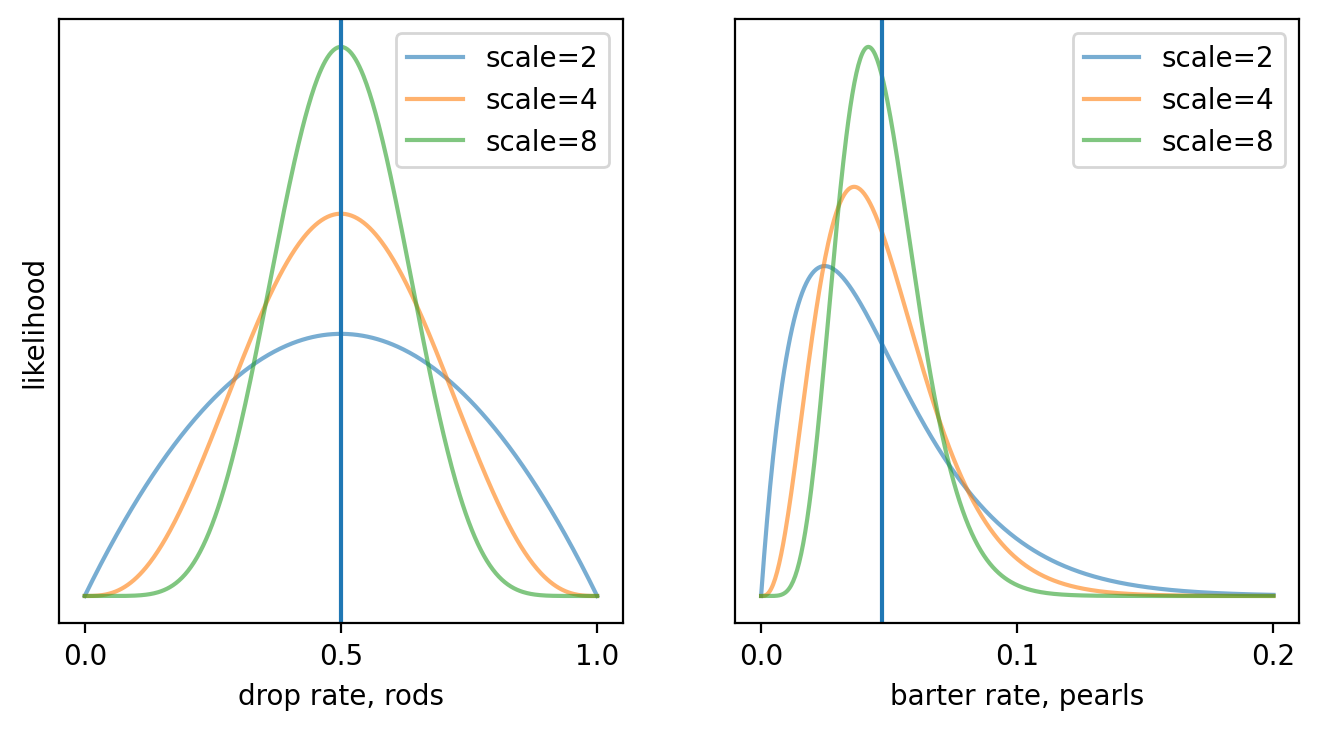

In [7]:
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')
(ax1, ax2) = fig.subplots(1, 2)

x = np.linspace(0,1,512)

scales = [2,4,8]
labels = [f'scale={scale}' for scale in scales]
r_blaze = Fraction(1,2)
r_pearl = Fraction(20,423)

for i,scale in enumerate(scales):

    blaze_prior = [float(x) for x in prior( r_blaze, scale )]
    ax1.plot(x, beta.pdf(x, *blaze_prior), '-', alpha=0.6, label=labels[i] )
    
    pearl_prior = [float(x) for x in prior( r_pearl, scale )]
    ax2.plot(x/5, beta.pdf(x/5, *pearl_prior), '-', alpha=0.6, label=labels[i] )
    

ax1.legend()
ax1.set_xticks([0,.5,1])
ax1.set_xlabel('drop rate, rods')
ax1.set_yticks([])
ax1.set_ylabel('likelihood')
ax1.axvline( r_blaze )

ax2.legend()
ax2.set_xticks([0,.1,.2])
ax2.set_xlabel('barter rate, pearls')
ax2.set_yticks([])
ax2.axvline( r_pearl )

plt.show()

The priors presented in Figure \ref{fig:sub_priors} are all quite subjective, and ask you to make a judgement call on the appropriate scale value to use. I think 4 is a good compromise, but it's simple enough to keep $\alpha_\text{prior}$ and $\beta_\text{prior}$ as free parameters. If you disagree with my choice of Beta prior, you are free to substitute any other. I'll also do a sensitivity analysis where I vary the prior strength with real-world data to help judge how strongly the conclusion is determined by the prior.

The apparent skew on the Ender pearl prior is because we are fixing the mean instead of the maximal likelihood. As we'll be integrating across this prior, fixing the latter would bias us to assume the barter rate is higher.

## The Posterior Distribution for the Binomial and Negative Binomial 

We can now construct a posterior distribution for both the Binomial and Negative Binomial cases. 

The updating rule of Equation \ref{eqn:beta_update} only works for one run of $k$ successes via $n$ trials, distributed according to the Binomial, but it is simple enough to extend for multiple runs. Define $\vec n = \{n_1, n_2, \dots, n_c\}$ as a vector that contains the trial counts for all $c$ runs, and $\vec k = \{v_1, v_2, \dots, v_c\}$ as a vector for each success count. The resulting Beta posterior is

\begin{equation}
\text{Beta}( \alpha_\text{prior} + \sum_{j=1}^c k_j, \beta_\text{prior} + \sum_{j=1}^c (n_j - k_j), p ) = \frac{\Gamma\left(\alpha_\text{prior} + (\sum_{j=1}^c k_j) + \beta_\text{prior} + (\sum_{j=1}^c (n_j - k_j))\right)}{\Gamma(\alpha_\text{prior} + \sum_{j=1}^c k_j)\Gamma(\beta_\text{prior} + \sum_{j=1}^c (n_j - k_j))} p^{\alpha_\text{prior} - 1 + \sum_{j=1}^c k_j} (1-p)^{\beta_\text{prior} - 1 + \sum_{j=1}^c (n_j - k_j)} \label{eqn:beta_binom_mess}
\end{equation}

Equation \ref{eqn:beta_binom_mess} is a bit ugly to look at. One way to clean it up is to use different notation. The [Taxicab norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm) is defined as

\begin{equation}
\|\vec n\|_1 = \sum_{j=1}^c |n_j|,
\end{equation}

and since no value contained by $\vec n$ or $\vec k$ are negative this substitution won't screw up the math. Note as well that

\begin{equation}
\sum_{j=1}^c (n_j - k_j) = \left(\sum_{j=1}^c n_j\right) - \left(\sum_{j=1}^c k_j\right) = \|\vec n\|_1 - \|\vec k\|_1,
\end{equation}

which, along with $\|\vec k\|_1 + \|\vec n\|_1 - \|\vec k\|_1 = \|\vec n\|_1$, allows us to rewrite Equation \ref{eqn:beta_binom_mess} as

\begin{equation}
\text{Beta}( \alpha_\text{prior} + \|\vec k\|_1, \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1))} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1)} \label{eqn:beta_binom_post}
\end{equation}

There's no need to normalize Equation \ref{eqn:beta_binom_post} to make it a probability distribution over $p$, as

\begin{equation}
\int_{p=0}^1 \text{Beta}(\alpha, \beta, p) = 1 \label{eqn:beta_integral}
\end{equation}

and therefore it is already normalized. That handles the case when $\vec k$ and $\vec n$ are taken from a Binomial distribution. What about the Negative Binomial case? Equation \ref{eqn:negbinom} shows the Negative Binomial is simply the Binomial times the probability of success, so in theory some math would give us a solution specifically tailored to the Negative Binomial. Unfortunately, that equation also shows the Negative Binomial isn't a probability distribution with respect to $p$.

In [8]:
n = 6
k = 3

# mp.quad() uses quadrature to numerically integrate. No math necessary on our side!
result = mp.quad( lambda p: p*binomial(n, k, p), (0,1) )

print( f'The integral of all possible p is {result}', end='' )
if result == Fraction(1,1):
    print( ', which means p*Binom(n,k,p) defines a probability distribution over p.')
else:
    print( '.' )

The integral of all possible p is 0.0714285714285714.


It is actually a probability distribution with respect to $n$. We must normalize it to create a true posterior, and the best time to do so is after extending the updating rule. First, observe that

\begin{align}
\sum_{j=1}^c (n_j - 1) &= \left(\sum_{j=1}^c n_j\right) - c = \|\vec n\|_1 - c \\
(\|\vec n\|_1 - c) - (\|\vec k\|_1 - c) &= \|\vec n\|_1 - \|\vec k\|_1,
\end{align}

and secondly, observe that we can rearrange the order we multiply without changing the final product. This allows us to write

\begin{align}
\text{posterior}_\text{Negative Binomial} &= p^c \left( \left( \prod_{j=1}^c \text{Binom}(n_j - 1, k_j - 1, p) \right)  \text{Beta}(\alpha_\text{prior}, \beta_\text{prior}, p) \right) \\
{} &= p^c \text{Beta}( \alpha_\text{prior} + \|\vec k\|_1 - c, \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) \\
{} &= p^c \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - c - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{align}

We can tidy that up a bit, as $p^a \cdot p^b = p^{a + b}$ and $c - c = 0$.

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \label{eqn:negbinom_unnormed}
\end{equation}

To normalize Equation \ref{eqn:negbinom_unnormed} according to $p$, we only need to divide it by integrating across $p$.

\begin{equation}
\int_{p=0}^1 \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{equation}

Note that all the Gamma functions are unaffected by any change in $p$. As $\int_x c \cdot g(x) = c \int_x g(x)$, we can pull them out of the integral. Since the same value is present in the numerator, all the Gamma functions cancel and we are left with

\begin{equation}
\int_{p=0}^1 p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{equation}

to evaluate. While this may seem daunting, remember that the Beta distribution integrates to 1 across $p$. Thus we can exploit the prior trick to rearrange Equation \ref{eqn:beta_integral}, and find

\begin{align}
\int_{p=0}^1 \text{Beta}(\alpha, \beta, p) &= 1 \\
\int_{p=0}^1 \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1} &= 1 \\
\int_{p=0}^1 p^{\alpha-1}(1-p)^{\beta-1} &= \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \label{eqn:beta_trick}
\end{align}

Equation \ref{eqn:beta_trick} will be incredibly handy in future, but for now it allows us to finish normalizing Equation \ref{eqn:negbinom_unnormed}.

\begin{align}
\alpha - 1 &= \alpha_\text{prior} + \|\vec k\|_1 - 1 \\
\alpha &= \alpha_\text{prior} + \|\vec k\|_1 \\
\beta &= \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 \\
\text{posterior}_\text{Negative Binomial} &= \frac{p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}}{\frac{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 )\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}{\Gamma(\alpha_\text{prior} + \beta_\text{prior} \|\vec n\|_1)} } \\
{} &= \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \label{eqn:beta_negbinom_post}
\end{align}

This is identical to Equation \ref{eqn:beta_binom_post}.\footnote{This is also why I didn't bother showing the derivation of the Beta update rule: calculating $\text{Binom}(n,k,p) \cdot \text{Beta}(\alpha, \beta, p)$ is trivially harder than $p \cdot Beta(\alpha, \beta, p)$, and the renormalization process is exactly the same. The extension from $k$ and $n$ to $\vec k$ and $\vec n$ is also trivial.} The PE report was correct to raise the possibility that barters and drops do not follow the Binomial distribution (pg. 7), but an analyis that used the Negative Binomial instead would come to the same conclusion. The MST report is also incorrect when they state that the Binomial distribution is "a very good approximation" (pg. 10) for barters/drops, in reality it leads to the exact same outcome as assuming the Negative Binomial instead.

The posterior from Equation \ref{eqn:beta_negbinom_post} is worth seeing in action. We'll apply it to the toy example from Listing \ref{code:negbinom_exam}, using the prior I defined earlier.

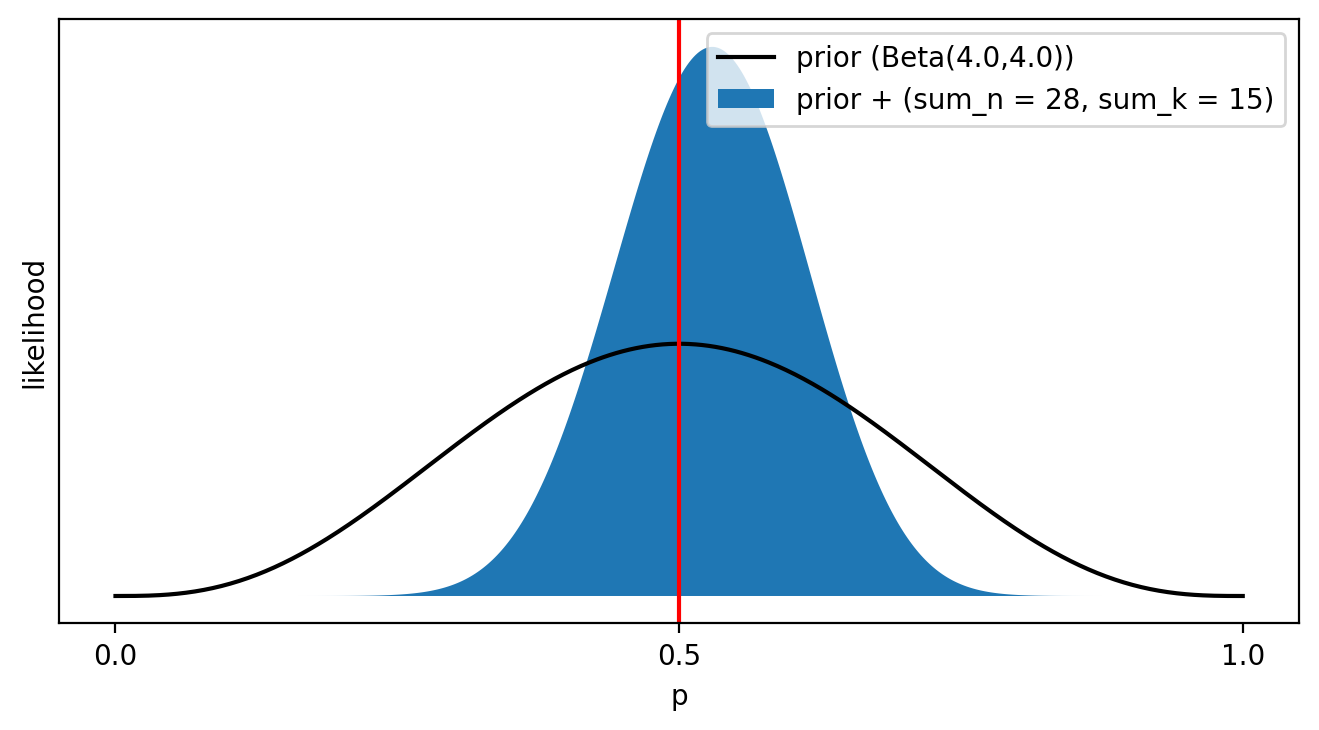

In [9]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.plot( x, beta.pdf( x, my_prior[0], my_prior[1]), '-k', \
         label=f'prior (Beta({my_prior[0]:.1f},{my_prior[1]:.1f}))')
plt.axvline( 0.5, color='red' )

plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

Figure \ref{fig:posterior_in_action} holds few surprises. Our credence over the Blaze rod drop rate began quite diffuse with the prior. Adding the simulation data grouped our credence more tightly together, making extremely low or high drop rates very unlikely. At the same time, the limited evidence allows drop rates close to $p = 0.5$ to remain very credible, and thanks to the nature of randomness the maximally likely drop rate of the posterior is not the actual value.

## Defining Fairness

Presenting a range of credible values isn't sufficient, as we have a specific hypothesis to test. The words "did Dream cheat?" do not have an obvious mathematical interpretation, but some interpretations are superior to others.

The easiest way to start is not by defining cheating, but instead defining fair play. We know unaltered Minecraft code sets the drop rate to 0.5, so why not define fairness by $\text{Beta}( \alpha_\text{posterior}, \beta_\text{posterior}, 0.5)$?

In [10]:
print( 'The likelihood I was playing fair in my simulation is' +
      f' {beta.pdf( 0.5, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k)} .')

The likelihood I was playing fair in my simulation is 4.490060385433022 .


The most glaring problem is that the output of the posterior is a likelihood, which isn't normalized like a probability is. We need to find some way to scale or modify that value so that it maps to something more meaningful to us.

But there's a more subtle problem here. Imagine an idealized dart board, centered at the origin of a 2D cartesian plane and with radius 1. Now pick a point on that dart board, and ask yourself the odds of an ideal dart hitting that point. The answer must be zero: since the dart board contains an [uncountably infinite](https://mathworld.wolfram.com/UncountablyInfinite.html) number of points, the odds of a dart hitting any one point is zero. Since the point we chose was arbitrary, we must conclude the odds of an ideal dart hitting our ideal dart board are zero. And yet clearly an ideal dart cast at that board must hit some point.

The solution is not to work with infinitely small points, but instead areas. If we expand the point in question to encompass a finite area, the probability becomes non-zero. Likewise, I could collect Blaze rods in Minecraft until the day I die, and the odds of me getting an exact 50\% drop rate would be incredibly small even if I was playing with an unmodified version of Minecraft. Instead, when assessing fairness we should consider a range of possible drop rates. Where do we place the ends of the range, however?

One possibility comes from coin flipping. That process has been considered fair for a long time, and is often relied on as a source of randomness. One researcher decided to test how fair a coin toss actually is, by asking medical residents to try biasing their coin flips in order to earn a \$20 prize. They were given a few weeks' notice before they were asked to flip a coin 300 times.

> This study shows that when participants are given simple instructions about how to manipulate the toss of a coin and only a few minutes to practise this technique, more than half can significantly manipulate the outcome. With devoted training, more participants would probably be able to achieve this figure, and the magnitude of the manipulation would probably be increased.\cite{ClarkE306}

One way to reconcile these two observations is to essert that a coin toss is "fair enough." Even if it is easy to bias a coin toss, the amount of bias may not be enough to matter in the context of where coin tosses are used. If we take the average bias of coin tosses in this study as our "fair enough" threshold, then fair constitutes no more than an $\frac{569}{500}$ improvement in the odds over perfect fairness, or in this case a success rate of 56.9\%. We could express that in mathematics as

\begin{equation}
\int_{p=0.431}^{0.569} \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p)
\end{equation}

This definition also has problems, though. Suppose I decided to modify my copy of Minecraft so that Blaze rods dropped 53\% of the time. In the short run this is quite undetectable, but what happens when I do 200 runs where I target seven Blaze rods.

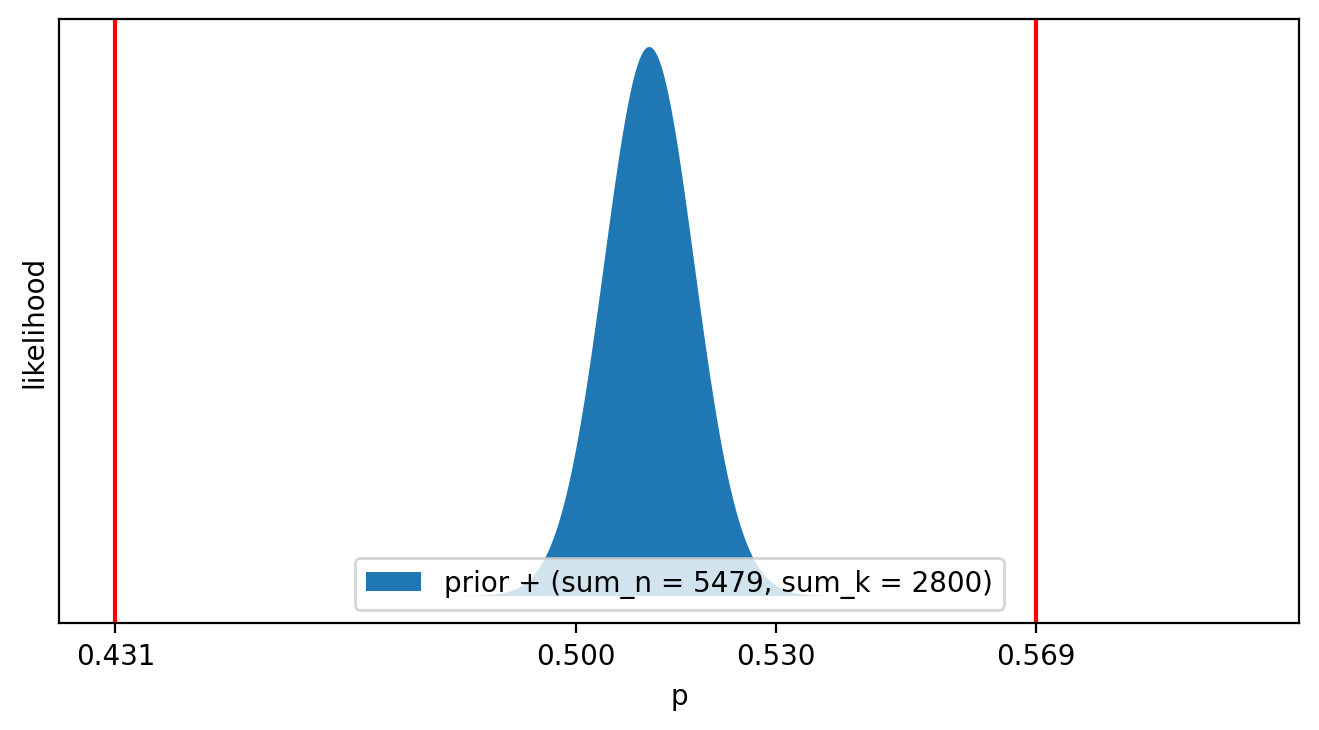

In [11]:
random  = np.random.default_rng(26)

k = 7     # number of Blaze rods needed
c = 400   # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = sum_k + np.sum(random.negative_binomial( k, 0.52, size=c ))

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(.45,.6,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.axvline( 0.431, color='red' )
plt.axvline( 0.569, color='red' )

plt.xticks([.431, .5,.53,.569])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

The posterior in Figure \ref{fig:fixed_fairness_bad} appears to provide strong evidence that I altered my drop rate,  as little credence is massed around $p = \frac 1 2$. Yet almost all of the credence lies within the bounds of integration, so our integral's value would be little different than if the mass had been much more clustered around the halfway mark. $H_\text{fair}$ don't just need to integrate over a range, its must "tighten up" as more data arrives.

Consider a version of Minecraft that swapped out the pseudo-random number generator with a sophisticated deterministic algorithm. This could detect the number of Blaze rods I want over the time period I'm playing, and automatically ensure exactly half of the Blazes I kill will drop Blaze rods. If I fed this fair algorithm into the math and generated a posterior, for the $\|\vec n\|_1 = 28$ case I would get

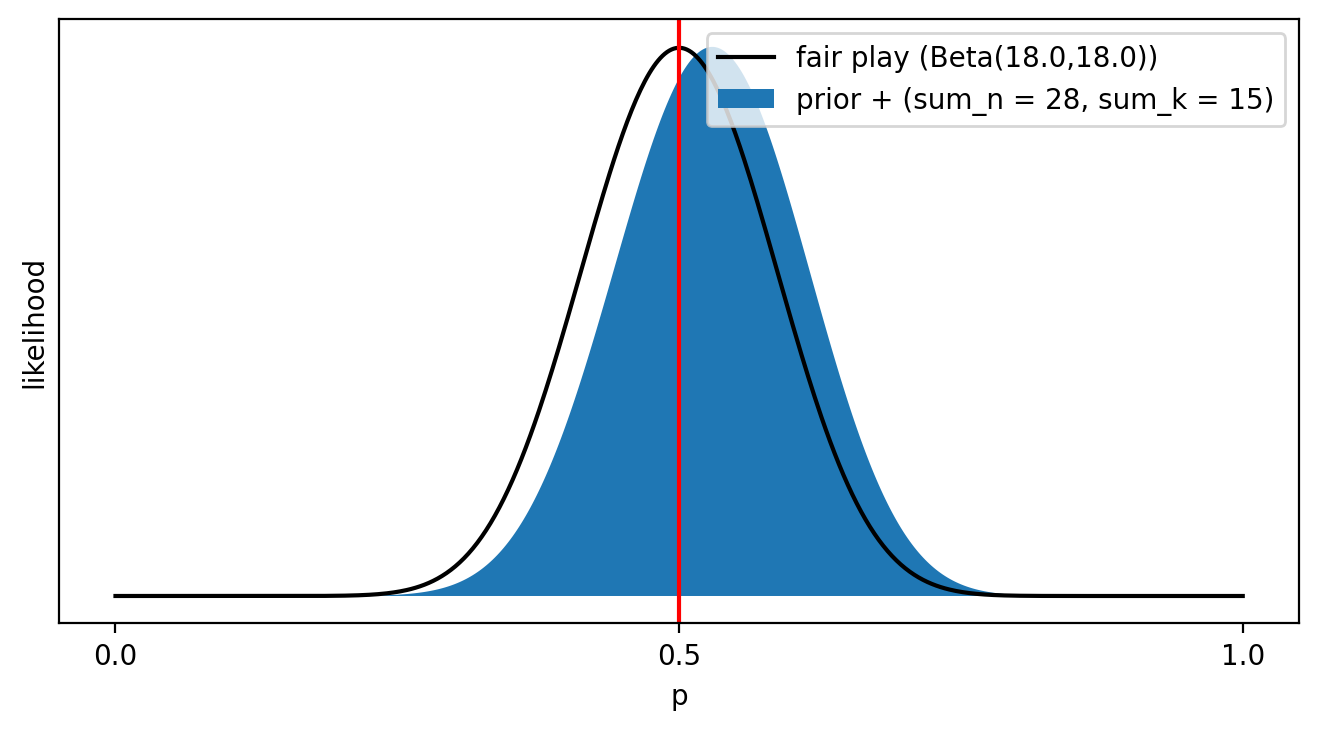

In [12]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.plot( x, beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2), '-k', \
         label=f'fair play (Beta({my_prior[0] + sum_n/2:.1f},{my_prior[1] + sum_n/2:.1f}))')
plt.axvline( 0.5, color='red' )

plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

I consider this a really good match for $H_\text{fair}$, as it nicely satisfies all the above requirements. You might have thought of a problem, though: what if I'd killed 27 Blazes instead of 28? Or, to take a more extreme example, if your copy of Minecraft 1.16.1 is unmodified you'll get 20 Ender pearl barters on 423 attempts. Those two numbers are co-prime, so the number of successful pearl barters will only be an integer so long as the number of attempts is a multiple of 423. It would be terribly inconvenient if we had to wait for 423 barters before we could start our analysis.

This is where the Gamma function really shines, as it's defined for fractions. When calculating $H_\text{fair}$ for Ender pearl barters, we're not forced to assign 20 successes for every 423 barters, we can instead assign $\frac{20}{423}$ successes for every barter. $H_\text{fair}$ is defined for arbitrary numbers of barters or drops.

Let's lock the mathematics for $H_\text{fair}$ down.

\begin{equation}
H_\text{fair}( p ~|~ \|\vec n\|_1 ) = \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p ), \label{eqn:h_fair}
\end{equation}

where $r_\text{fair}$ is the rate we expect during fair play. For instace, $r_\text{blaze} = \frac 1 2$ and $r_\text{pearl} = \frac{20}{423}$.

If you do not agree with my definition of "fair play" according to Equation \ref{eqn:h_fair}, I'd encourage you to think up your own and express it in a mathematically precise way. In the meantime, I'll multiply $H_\text{fair}(\vec n)$ by the posterior and integrate.

\begin{equation}
\int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( \vec n, p ) = \int_{p=0}^1 \text{Beta}( \alpha_\text{prior} + \|\vec k\|_1 , \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) \cdot \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p )
\end{equation}

\begin{equation}
{} = \int_{p=0}^1 \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)} p^{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1 - 1} 
\end{equation}

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)^2}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)} \int_{p=0}^1  p^{2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 2} (1-p)^{2 \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1  + (1-r_\text{fair})\|\vec n\|_1 - 2}
\end{equation}

\begin{equation}
\|\vec n\|_1 + (1-r_\text{fair})\|\vec n\|_1 = (2 -r_\text{fair})\|\vec n\|_1
\end{equation}

\begin{equation}
\int_{p=0}^1  p^{2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 2} (1-p)^{2 \beta_\text{prior} + - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 2} = \frac{\Gamma(2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 1)\Gamma(2 \beta_\text{prior} - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 1)}{\Gamma(2 \alpha_\text{prior} + 2 \beta_\text{prior} + 2\|\vec n\|_1 - 2)}
\end{equation}

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)^2 \Gamma(2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 1)\Gamma(2 \beta_\text{prior} - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 1) }{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)\Gamma(2 \alpha_\text{prior} + 2 \beta_\text{prior} + 2\|\vec n\|_1 - 2)} \label{eqn:posterior_h_fair}
\end{equation}

Equation \ref{eqn:posterior_h_fair} isn't as tidy as we'd hoped, but at least that integral is gone. Evaluating it looks very difficult, but I have an ace up my sleeve. `mpmath` is a Python library that allows you to do calculations with arbitrary precision. This is handy when dealing with very large numbers, because with conventional floating-point math there's a chance you could overflow and have everything break. One function in that library, `mpmath.gammaprod()`, allows you to calculate fractions with arbitrary numbers of Gamma functions in the numerator or denominator. It makes evaluating messes like Equation \ref{eqn:posterior_h_fair} a snap. Let's fix $\|\vec n\|_1 = 28$ and $r_\text{fair} = \frac 1 2$, apply my prior of $\alpha_\text{prior} = \beta_\text{prior} = 4$, and see what we get for all possible values of $\|\vec k\|_1$.

In [13]:
def posterior_H_fair( vec_k, vec_n, r_fair, a_prior, b_prior ):
    """Calculate the likelihood of H_fair, given the posterior distribution defined by vec_n, vec_k, and the prior.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total or list containing the successful attempts at this task until it was completed.
    vec_n: A total or list containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha variable of the prior.
    b_prior: A positive or zero float representing the beta variable of the prior.
    
    Returns
    -------
    The likelihood, an mpmath float in the range [0,infinity]."""

    # place some imports here to encourage copy-paste coding
    from mpmath import gammaprod
    from numpy import sum        # vectorized, likely faster than Python's sum
    
    # the downside of encouraging copy-pasting is that this code will face some
    #  dirty/invalid inputs. By going wild with asserts, I'm making it tougher to
    #  use this function inappropriately.
    assert (r_fair > 0) and (r_fair < 1)
    assert (a_prior >= 0) and (b_prior >= 0)
    
    # use duck typing to determine whether these are lists or not
    try:
        len_k = len(vec_k)
        k_is_list = True
    except TypeError:
        len_k = 1
        k_is_list = False

    try:
        len_n = len(vec_n)
        n_is_list = True
    except TypeError:
        len_n = 1
        n_is_list = False
   
    # do additional checks if both are lists
    if k_is_list and n_is_list:
        
        assert len_k == len_n
        for i,n in enumerate(vec_n):
            assert n > 0
            assert (vec_k[i] >= 0) and (vec_k[i] <= n)
                  
    # now calculate sums      
    if k_is_list:
        sum_k = sum(vec_k)
    else:
        sum_k = vec_k
        
    if n_is_list:
        sum_n = sum(vec_n)
    else:
        sum_n = vec_n
        
    # one final round of checks
    assert sum_n >= 1
    assert (sum_k >= 0) and (sum_k <= sum_n)

    # calculate the final result
    numerator =   [a_prior + b_prior + sum_n, a_prior + b_prior + sum_n,
                  2*a_prior + sum_k + r_fair*sum_n - 1,
                  2*b_prior - sum_k + (2 - r_fair)*sum_n - 1]
    denominator = [a_prior + sum_k, b_prior + sum_n - sum_k,
                   a_prior + r_fair*sum_n, b_prior + (1 -r_fair)*sum_n,
                  2*(a_prior + b_prior + sum_n - 1)]
    
    return gammaprod(numerator, denominator)

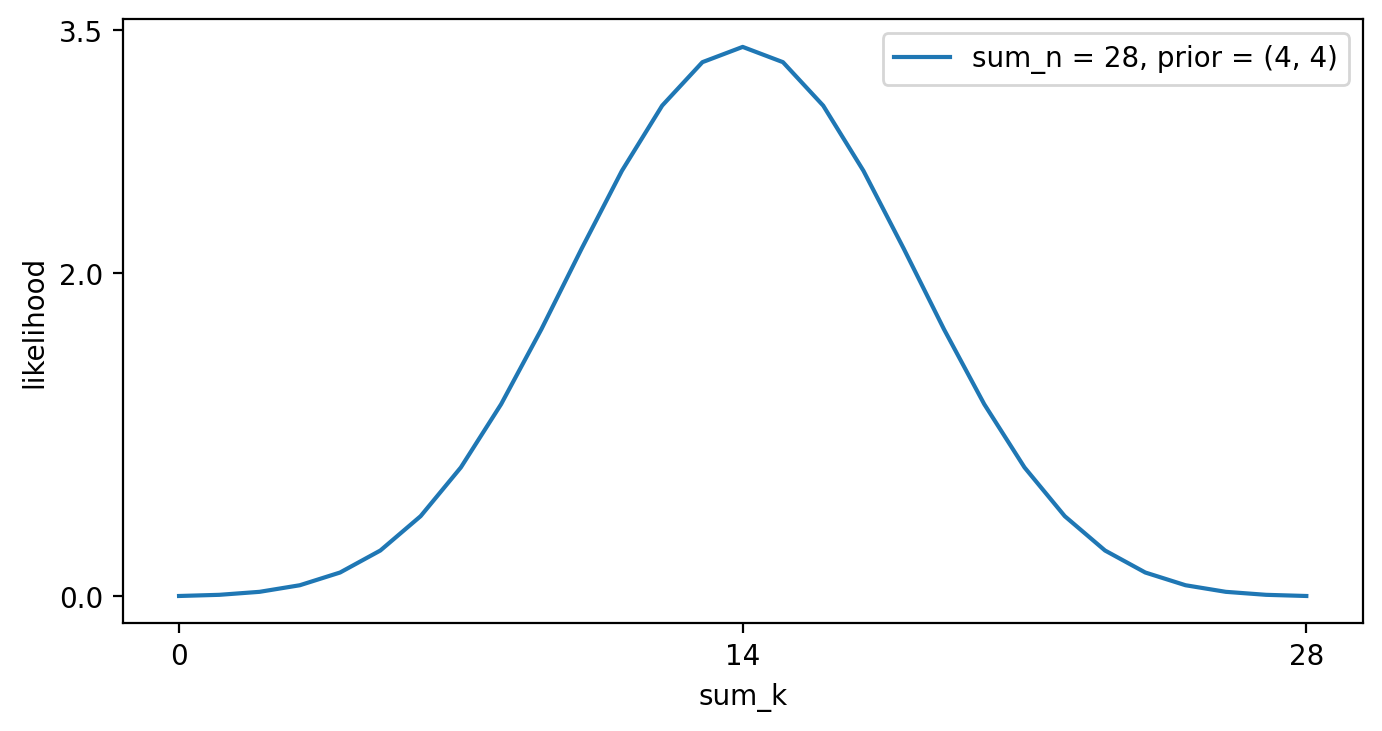

In [14]:
sum_n  = 28
r_fair = Fraction(1,2)
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.arange(sum_n + 1)
plt.plot( x, [posterior_H_fair( v, sum_n, r_fair, a_prior, b_prior ) for v in x], '-', \
        label=f'sum_n = {sum_n}, prior = ({a_prior}, {b_prior})')

plt.ylabel("likelihood")
plt.yticks([ 0, 2, 3.5 ])

plt.xlabel('sum_k')
plt.xticks([ 0, 14, 28 ])

plt.legend()
plt.show()

Figure \ref{fig:posterior_H_fair} behaves much as we'd expect. $H_\text{fair}$ is maximized when $\|\vec k\|_1 = r_\text{fair}\|\vec n\|_1$, remains quite high for nearby values, but rapidly drops off as $\|\vec k\|_1$ diverges.

## Defining a Reference Point

Figure \ref{fig:posterior_H_fair} also demonstrates that we're still dealing with raw likelihoods. We still need that reference point.

The usual solution is to calculate a Bayes factor. You've likely seen Bayes' Theorem,

\begin{equation}
p( H_1 | E ) = \frac{p( E | H_1 ) p( H_1 )}{p(E)}
\end{equation}

The likelihood function $p( E | H_1 )$ and prior $p( H_1 )$ should be familiar enough by now. The normalization factor $p( E )$ is the probability of observing the evidence over all possible hypotheses. We've managed to avoid it by invoking conjugate priors, specifically by starting with a prior that's universal to all hypotheses worthy of consideration. Once we apply a specific hypothesis, or use another method of calculation, $p( E )$ becomes non-trivial to calculate.

The ideal solution is to define a second hypothesis, say $H_2$, and divide.

\begin{equation}
\frac{p( H_1 | E )}{p( H_2 | E )} = \frac{p( E | H_1 ) p( H_1 )}{p( E | H_2 ) p( H_2 )} \label{eqn:bayes_factor}
\end{equation}

This "Bayes factor" eliminates the need to calculate $p(E)$, and constants across the numerator ond denominator cancel out so computation is easier. It has the same interpretation as betting odds, with numbers greater than 1 indicating $H_1$ is favoured and vice-versa. It also has none of the flaws of p-values, for instance it obeys all the properties of a likelihood so combining multiple Bayes factors together is as simple as multiplying them.

In this context, the only worthwhile second hypothesis is "did Dream cheat?". Unfortunately, while there's only one $r_\text{fair}$ there are many ways to cheat. Ideally we'd consult with experts about Minecraft speedrunning and develop a mathematically-precise hypothesis about what cheating looks like. Since I do not have those connections, I'll use a backup strat.

If we accept my definition of $H_\text{fair}$, we can define $H_\text{cheat}$ as the inverse of that definition; where $H_\text{fair}$ asserts fair play is likely, $H_\text{cheat}$ asserts it is unlikely, and vice-versa. The easiest way to accomplish that is to subtract the likelihood output by $H_\text{fair}$ from some other value. This value must be high enough to prevent the result from ever being negative, and not so high that it waters down the negation of $H_\text{fair}$. The obvious choice is to use the maximal likelihood of $H_\text{fair}$ as that value, which is

\begin{align}
m_\text{fair} &= \frac{\alpha - 1}{\alpha + \beta - 2} = \frac{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1}{\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - 2} \\
M_\text{fair} &= \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, m_\text{fair})
\end{align}

There are three flaws with using $M_\text{fair} - H_\text{fair}$ as $H_\text{cheat}$. This hypothesis gives maximal credence to both $p = 0$ and $p = 1$, and yet no cheater would dare set their probability of success to those values. Fortunately, my choice to go with a subjective prior already factored that in. If you go with another prior, either alter it the same way or adjust $M_\text{fair} - H_\text{fair}$ appropriately.

This hypothesis also states that if $\|\vec k\|_1 = r_\text{fair}\|\vec n\|_1$, the likelihood of cheating is zero. Yet we can easily concoct scenarios where a run of bad luck happens to result in a record that appears perfectly fair. In comparison, $H_\text{fair}$ has no zeros except at $p = 0$ and $p = 1$. A better alternative is to add some small offset to model to capture the small but ever present possibility of cheating by unknown means. For the same reason $H_\text{fair}$ scales with $\|\vec n\|_1$, it would be wise to scale this offset by the inverse of that value.

I propose $\frac 1 2 \|\vec n\|_1^{-1}$ is a good choice. Consider an ideal Bernouilli process representing evidence towards some hypothesis. As we know nothing about this process, "non-informative" priors\footnote{The scare quotes are because there's a strong argument to be made all priors leak information into the posterior, as what we consider "uninformative" according to one parameterization may not be the same with another.\cite{syversveen1998noninformative} It's better to aim for weakly-informative than non-informative.} make more sense than a subjective one. What I consider to be the best-justified "non-informative" prior is the Jeffrey's prior, which in this case is $\text{Beta}(\frac 1 2, \frac 1 2)$. If all $\|\vec n\|_1$ atoms of evidence pulled from this process goes against the hypothesis, the mean value for the probability of truth $p$ is

\begin{equation}
\frac{ \frac 1 2 }{ \frac 1 2 + \|\vec n\|_1} \approx \frac 1 {2\|\vec n\|_1}
\end{equation}

I can keep the constant factor separate, so if you do not agree with it you can supply an alternative or eliminate the offset entirely by setting the constant to zero.

Third and finally, $M_\text{fair} - H_\text{fair} + \frac 1 2 \|\vec n\|_1^{-1}$ is not normalized when integrated by $p$, a requirement if we're to compare it against $H_\text{fair}$. This is quite simple, as

\begin{align}
\int \left( g(x) + h(x) \right) &= \left( \int g(x) \right) + \left( \int h(x) \right) \\
\int_{p=0}^1 t &= \left. t\cdot p \right|_{p=0}^1 = t\cdot(1) - t\cdot(0) = t
\end{align}

so therefore

\begin{align}
\int_{p=0}^1 M_\text{fair} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p ) + \frac 1 {2 \|\vec n\|_1} &= M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1
\end{align}

and we can finally write out $H_\text{cheat}$.

\begin{align}
H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) &= \frac{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p) }{M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1}, \label{eqn:H_cheat} \\
M_\text{fair} &= \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, m_\text{fair}) \\
m_\text{fair} &= \frac{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1}{\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - 2}
\end{align}

For the toy example above, Equation \ref{eqn:H_cheat} looks like

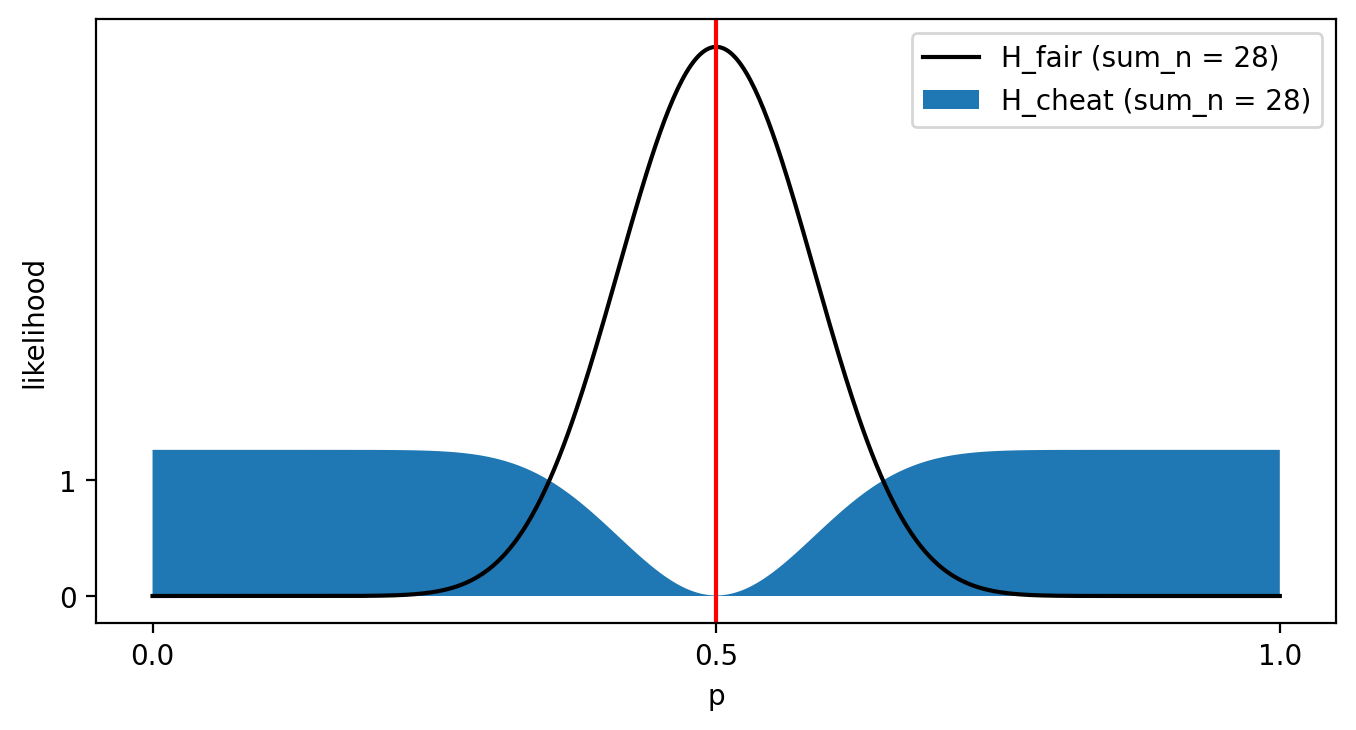

In [15]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)

    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
m = (my_prior[0] + sum_n/2 - 1) / (sum(my_prior) + sum_n - 2)
M = beta.pdf( m, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2)
plt.fill_between( x, (M - beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2) + (.5/sum_n))/(M-1+(.5/sum_n)), \
         label=f'H_cheat (sum_n = {sum_n})')

plt.plot( x, beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2), '-k', label=f'H_fair (sum_n = {sum_n})')
plt.axvline( 0.5, color='red' )


plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([0,1])
plt.ylabel('likelihood')

plt.legend()
plt.show()

## Putting It All Together

We finally have enough math in place to calculate a Bayes factor.

\begin{align}
\text{BF} &= \frac{ \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) }{ \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) } \\
\int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) &= \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) \frac{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p) }{M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1} \\
{} &= \frac 1 {M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1} \left( M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) \right) \\
\text{BF} &= \frac{ \left(M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1\right) \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) }{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) } \label{eqn:BF_H_fair_H_cheat}
\end{align}

Notice that Equation \ref{eqn:BF_H_fair_H_cheat} uses the integral required to apply $H_\text{fair}$, so the function I wrote above can be recycled to make the implementation shorter.

In [16]:
def BF_H_fair_H_cheat( vec_k, vec_n, r_fair, a_prior, b_prior, sum_n_weight=0.5 ):
    """Calculate the Bayes factor associated with H_fair / H_cheat, given the posterior distribution defined by vec_n, vec_k, and the prior.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total or list containing the successful attempts at this task until it was completed.
    vec_n: A total or list containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha variable of the prior.
    b_prior: A positive or zero float representing the beta variable of the prior.
    sum_n_weight: A positive or zero float that's used to weight the ||vec_n|| component. Defaults to 1/2.
    
    Returns
    -------
    The Bayes factor, a likelihood and mpmath float in the range [0,infinity]. Values greater than 1 favour
       fairnes, values below 1 favour cheating."""
    
    from mpmath import fdiv, fmul, gammaprod, power
    
    # validate our one new variable
    assert sum_n_weight >= 0
    
    # rely on posterior_H_fair()'s assertions to validate the remaining inputs
    integral = posterior_H_fair( vec_k, vec_n, r_fair, a_prior, b_prior )
    
    # but we still need sum_n for calculations
    try:
        len_n = len(vec_n)
        n_is_list = True
    except TypeError:
        len_n = 1
        n_is_list = False  
                 
    if n_is_list:
        sum_n = sum(vec_n)
    else:
        sum_n = vec_n

    
    # invoke mpmath instead of python's functions, to discourage precision loss
    m = fdiv( a_prior + r_fair*sum_n - 1,  a_prior + b_prior + sum_n - 2 )
    M = fmul( gammaprod([a_prior + b_prior + sum_n], [a_prior + r_fair*sum_n,b_prior + (1-r_fair)*sum_n]), \
             fmul(power( m, a_prior + r_fair*sum_n - 1 ), power( 1-m, b_prior + (1-r_fair)*sum_n - 1 )) )

    return fdiv( fmul(M - 1 + sum_n_weight/sum_n, integral), M + sum_n_weight/sum_n - integral )

Let's validate `BF_H_fair_H_cheat()` against the toy example, as well.

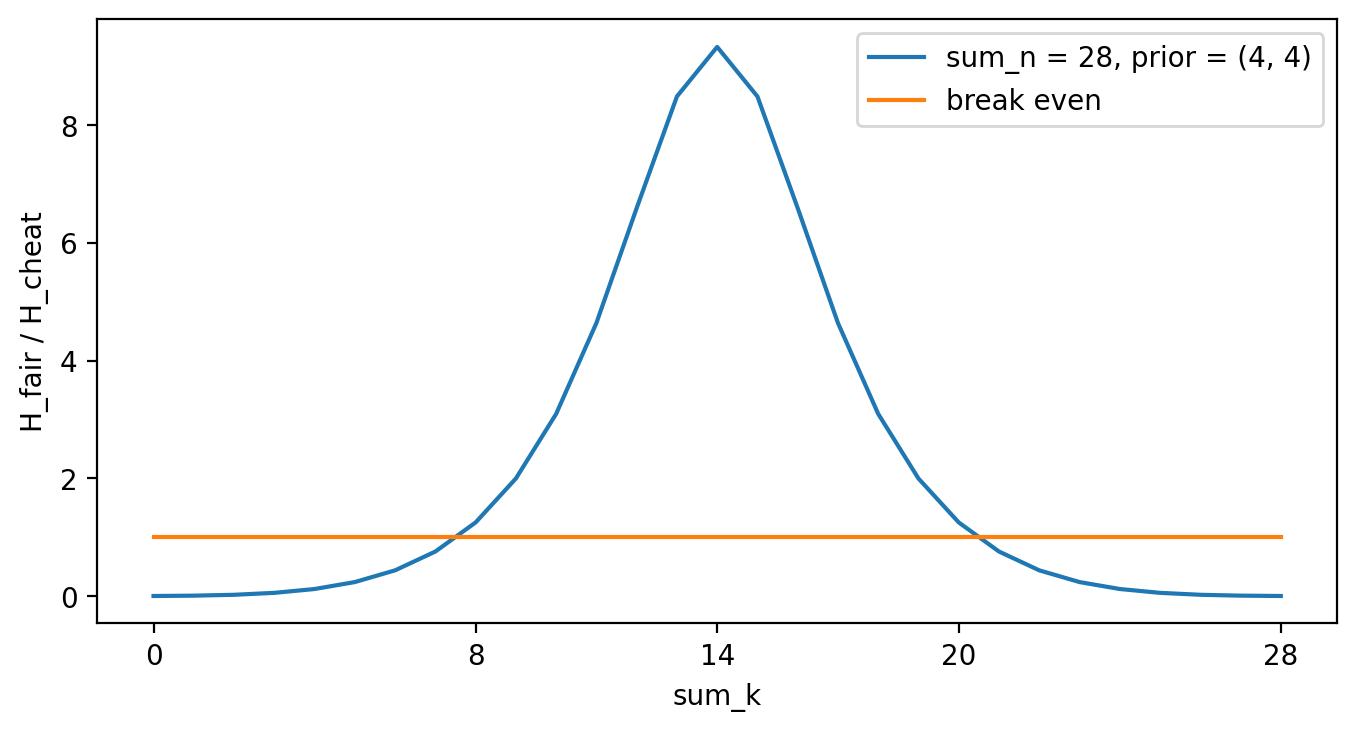

In [17]:
sum_n  = 28
r_fair = Fraction(1,2)
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.arange(sum_n + 1)
plt.plot( x, [BF_H_fair_H_cheat( v, sum_n, float(r_fair), a_prior, b_prior ) for v in x], '-', \
        label=f'sum_n = {sum_n}, prior = ({a_prior}, {b_prior})')
plt.plot( x, [1 for v in x], '-', \
        label='break even')

plt.ylabel("H_fair / H_cheat")
# plt.yscale('log')

plt.xlabel('sum_k')
plt.xticks([ 0, 8, 14, 20, 28 ])

plt.legend()
plt.show()

Figure \ref{fig:BF_posterior_H_fair} is as expected. The sharper peak than Figure \ref{fig:posterior_H_fair} is due to the increasing likelihood of $H_\text{cheat}$ given a $\|\vec k\|_1$ that diverges from perfect fairness. Values of $\|\vec k\|_1$ near $r_\text{fair}$ are nonetheless considered net evidence in favour of $H_\text{fair}$, while values far from there count as evidence for $H_\text{cheat}$. The crossover point is about six and a half possible values of $\|\vec k\|_1$ away from perfect fairness.

Another useful test is to fix $\|\vec k\|_1 = \frac 1 2 \|\vec n\|_1$ and increase $\|\vec n\|_1$. If you've done much frequentist analysis, you've noticed that a common scaling term is $\sqrt{n}$. This is a side-effect of the Central Limit Theorem applied to "well-behaved" distributions, where [it's been proven](https://en.wikipedia.org/wiki/Berry%E2%80%93Esseen_theorem) that estimates of true mean will converge to the true mean at a rate proportional to $\sqrt{n}$. We can think of that as metric of how strong the evidence is. Since Bernoulli processes fit in the definition of "well-behaved," our evidence for any fixed hypothesis should show the same scaling factor.

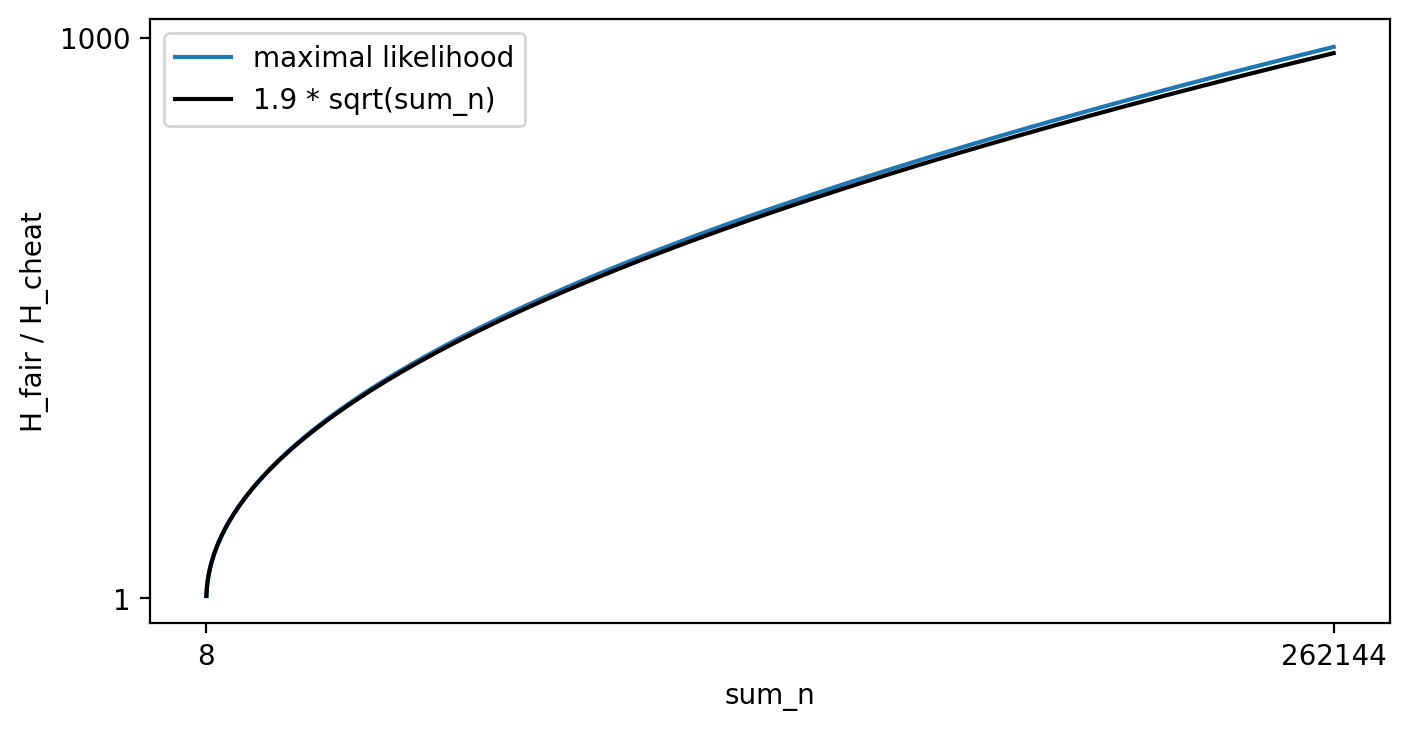

In [18]:
r_fair = 0.5
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.exp( np.linspace(np.log(8), np.log(1 << 18), 256) )
plt.plot( x, [BF_H_fair_H_cheat( v/2, v, float(r_fair), a_prior, b_prior ) for v in x], '-', \
        label=f'maximal likelihood')

plt.plot( x, 1.9*np.sqrt(x), '-k', label='1.9 * sqrt(sum_n)' )

plt.ylabel("H_fair / H_cheat")
plt.yticks([1, 1000])

plt.xlabel('sum_n')
plt.xticks([8, 1 << 18])

plt.legend()
plt.show()

As before, Figure \ref{fig:weight_evidence} holds no surprises. There is a subtle divergence between the theoretical and practical behavior of the Bayes factor. This is likely due to the $\frac 1 2 \|\vec n\|_1^{-1}$ term adding some skew when it has a large value.

# Simulation Results

Another way to validate this metric is to run it through some toy examples. If the Bayes factor shows odd behaviour, like suggesting a simulater player cheated when we know they did not, we have reason to be suspecious of it. This also allows us to get a feel for how it performs under different levels of evidence.

## Blaze Rod Drops

Blaze rod drops are the easiest to model, so we'll start with them. It's worth loading the MST report's data and pooling it together to generate a realistic target for $k$.

In [3]:
# missing the data files? Uncommenting and running this cell might retrieve them
# !mkdir data
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.benex.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.dream.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.illumina.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.sizzler.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.vadikus007.tsv"

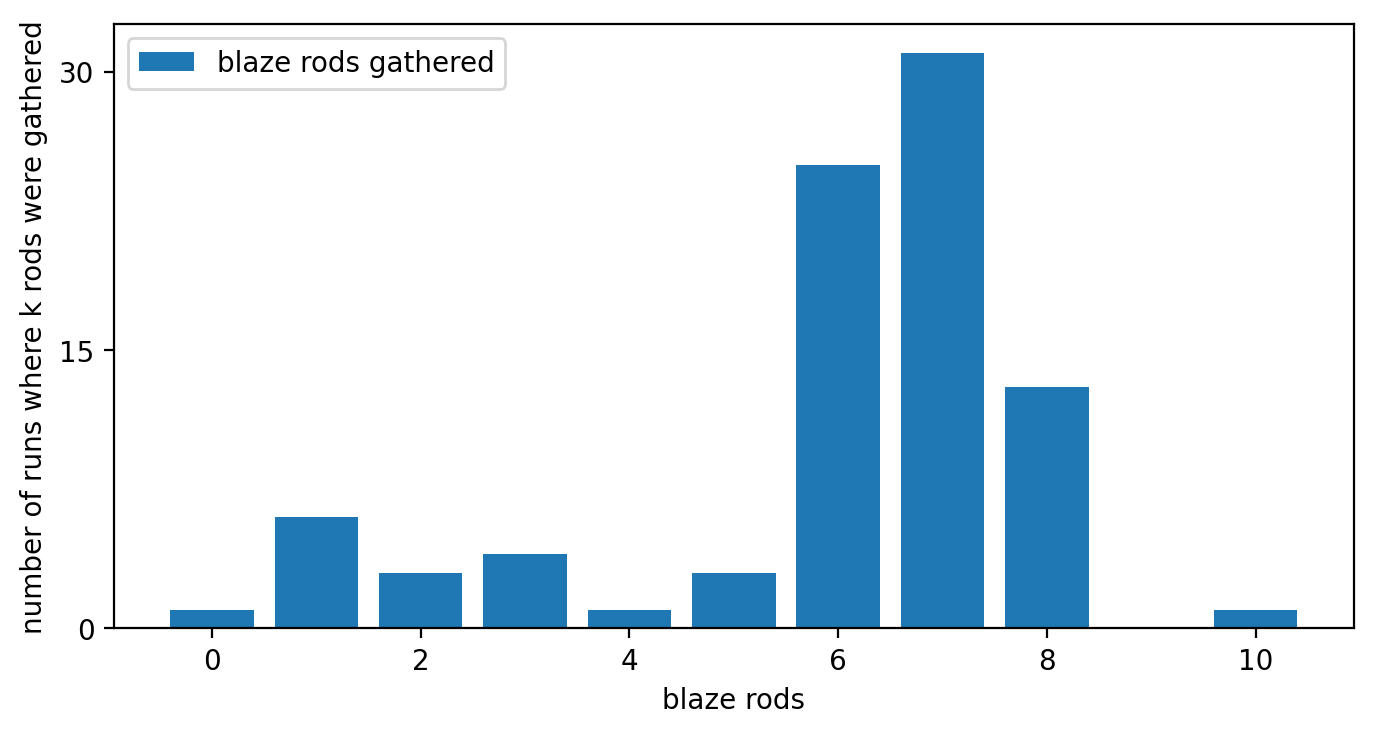

In [19]:
# the Ender pearl stats have slightly different names
blaze_players = ['benex','dream','illumina','sizzler','vadikus007']

# create a blank dataframe to ensure the proper format
all_blaze_rods = pd.DataFrame( {'n':[], 'k':[]} )

# load in the data
for p in blaze_players:
    all_blaze_rods = all_blaze_rods.append( pd.read_csv(f'data/blaze.{p}.tsv',sep="\t") )

# pull out all the unique values
blaze_k = sorted( all_blaze_rods['k'].unique() )
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

plt.bar( blaze_k, [all_blaze_rods['k'][ all_blaze_rods['k'] == k ].count() for k in blaze_k], \
        label='blaze rods gathered' )

plt.xlabel('blaze rods')
plt.ylabel('number of runs where k rods were gathered')
plt.yticks([0,15,30])

plt.legend()
plt.show()

Figure \ref{fig:blaze_rods_gathered} shows quite a variance on the number of rods speedrunners would gather. The values below five could be runs that failed for a variety of reasons; perhaps the runner was behind schedule and the drop rate too low, or they took too much damage or were tossed into lava. Five rods is the bare minimum I could see used to complete a speed run, as a runner could use only two Eyes of Ender to locate the Stronghold, have neither break, then 34.1\% of the time find that the End portal has two or more Eyes in it. That one run of ten rods comes from Benex, and the comments about going after Wither skeletons suggest it wasn't a typical speedrun. Excluding that creates a semi-Binomial lump of Blaze rod targets with seven as the most common goal.

We'll pick values of $k$ within those bounds, using the observed frequencies to weight which values are picked, then draw random values for $n - k$ based on them. We'll have one simulated runner playing an unmodified version of Minecraft 1.16 that has a Blaze rod drop rate of exactly 50\%, then two cheaters playing with modified drop rates. Since one random sequence cannot capture the full variability expected, we'll create fifteen clones of each of the three players and play out how this Bayes factor behaves for all them.

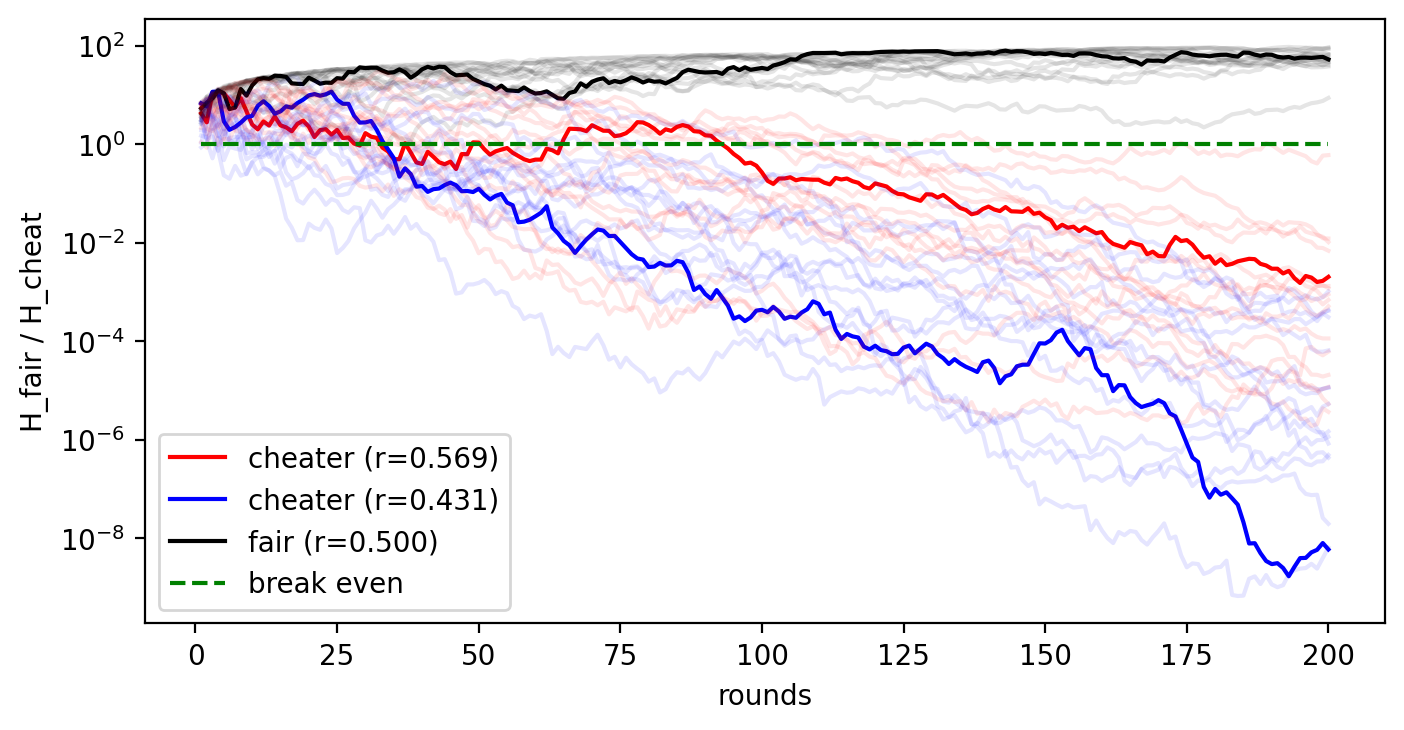

In [20]:
random  = np.random.default_rng(42)

# generate the weights and normalize
weights = np.array( [all_blaze_rods['k'][ all_blaze_rods['k'] == k ].count() for k in range(5,9)] )
weights = weights / np.sum(weights)

r_fair    = 0.5
r_cheat_h = 0.569
r_cheat_l = 0.431
count     = 200
clones    = 16
a_prior, b_prior   = prior(r_fair, 4)

x      = np.arange(1, count+1)
k      = 5 + random.choice( 4, size=(clones,count), p=weights )
sum_k  = np.cumsum( k, axis=1 )

cheat_h_nk = random.negative_binomial( k, r_cheat_h )
cheat_l_nk = random.negative_binomial( k, r_cheat_l )
fair_nk    = random.negative_binomial( k, r_fair )

sum_k         = np.cumsum( k, axis=1 )
sum_cheat_h_n = sum_k + np.cumsum( cheat_h_nk, axis=1 )
sum_cheat_l_n = sum_k + np.cumsum( cheat_l_nk, axis=1 )
sum_fair_n    = sum_k + np.cumsum( fair_nk, axis=1 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

for idx in range(clones):
    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_cheat_h_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-r', label=f'cheater (r={r_cheat_h:.3f})' )
    else:
        plt.plot( x, y, '-r', alpha=0.1 )

    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_cheat_l_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-b', label=f'cheater (r={r_cheat_l:.3f})' )
    else:
        plt.plot( x, y, '-b', alpha=0.1 )

    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_fair_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-k', label=f'fair (r={r_fair:.3f})' )
    else:
        plt.plot( x, y, '-k', alpha=0.1 )

plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:sim_blaze_trio} shows there are two distinct behaviours. For players with unmodified drop rates, the Bayes factor usually stays above one and appears to follow the $\sqrt{n}$ trajectory detailed earlier. For the two cheating players, the Bayes factor continually drifts below one and in some cases gets below 1:1,000,000 odds of playing fair. Randomness can play a factor, though, as one of the fair players' Bayes factors drifts downward toward the 1:1 odds range, and one of the cheaters manages roughly 1:1 odds of fair play during the entire session. There are also times where the cheating players have Bayes factors that suggest fair play, those these are only temporary and constrained to earlier rounds. Interestingly, the cheater that reduced their odds of a Blaze rod drop seems to have fared worse than the player that boosted their Blaze rod drops. One explanation is that while the Negative Binomial may be treated the same as the Binomial in the long run, always stopping on a positive will skew the results in the short term.

## Cheating Techniques

Why would a cheater want to reduce the number of Blaze rods they collect? Consider their point of view. They know that the odds of their cheating being detected are high if they simply increase their rate. Someone watching the stream will get suspicious, count up Blaze rods, and alert others. 

A big-brained play is to instead *temporarily* elevate the drop rate. We're used to thinking of people getting lucky from time to time, so a short run of unusually good luck might pass under the radar. Even if it doesn't they have a plausible excuse. The cheater can use the periods of normal drop rates to skill up, and only modify their game when they think they have a decent shot at a record. The problem with this technique is that it will always be true that $\|\vec k\|_1 > r_\text{fair}\|\vec n\|_1$ for them. No one may be able to detect their cheating in the short term, but a career-long analysis will show an elevated success rate relative to non-cheating players. The more times this cheater temporarily boosts their luck, the greater the evidence they've done exactly that.

A galaxy-brained move is to alternate between short periods of elevated drop rates and long periods of *deflated* drop rates. The PE report considers multiple "boost rates" for Ender pearl barters, but as the name implies it doesn't consider deflated rates. The MST report states that apparently elevated drop rates made the speedrunning community suspicious of Dream (pg. 3), and that any runner "observed experiencing such unlikely events would be held to the same level of scrutiny" (pg. 4); the flip side is that any runner experiencing an unusually low number of drops would not face that level of scrutiny. This blind spot of the speedrunning community can be exploited: by altering their drop rate both up and down, a cheating speedrunner can ensure their career stats do not reveal evidence of cheating. 

A greatly decreased drop rate would allow them more headroom for cheating, but also creates a large handicap to overcome. Since speed running requires a lot of grinding to build up skill, long periods of slightly-decreased luck would lower the handicap and allow the cheater a chance of unusually good luck during their grind. Should one of their elevated periods raise suspicion, not only can they pull out the "I got lucky" excuse, they can also point to a specific period of prior attempts and argue that, when taken as a whole, they demonstrate their drop rate is normal.  It will, because they've engineered that to be the case. The PE report analyzed the six attempts the MST report did for evidence of elevated drop rates, as well as those six plus five attempts Dream supplied them, but never considered analyzing those five attempts alone.

To be clear, I'm not accusing Dream of either type of cheating. I've deliberatly avoided doing the appropriate analysis before writing this text, in fact. When analyzing both reports for flaws, though, this oversight is easy to spot. It is also easy to detect, once you know what to look for, and the Bayes factor I've created is sensitive to both increased and decreased drop rates.\footnote{Incidentally, its greater sensitivity to deflated drop rates was a genuine surprise to me when I ran the simulation above.} An analysis that uses p-values might also be able to detect it if a "two-tailed" p-value is used, but the MST report opted to use a "one-tailed" p-value instead.\cite{doi:10.3102/0013189X020009013}

## Ender Pearl Barters

This analysis has primarily focused on Blaze rods, as they can be easily analogized to a flip of a coin and quite clearly follow a Negative Binomial. If the above math and analysis is correct, though, the exact same procedure should work for Ender pearl barters. The only difficult part is deciding whether to simulate those barters via the Negative Binomial or the Binomial.

In [2]:
# missing the data files? Uncommenting and running this cell might retrieve them
# !mkdir data
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.benex.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.dream_before.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.dream_after.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.illumina.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.sizzler.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.vadikus007.tsv"

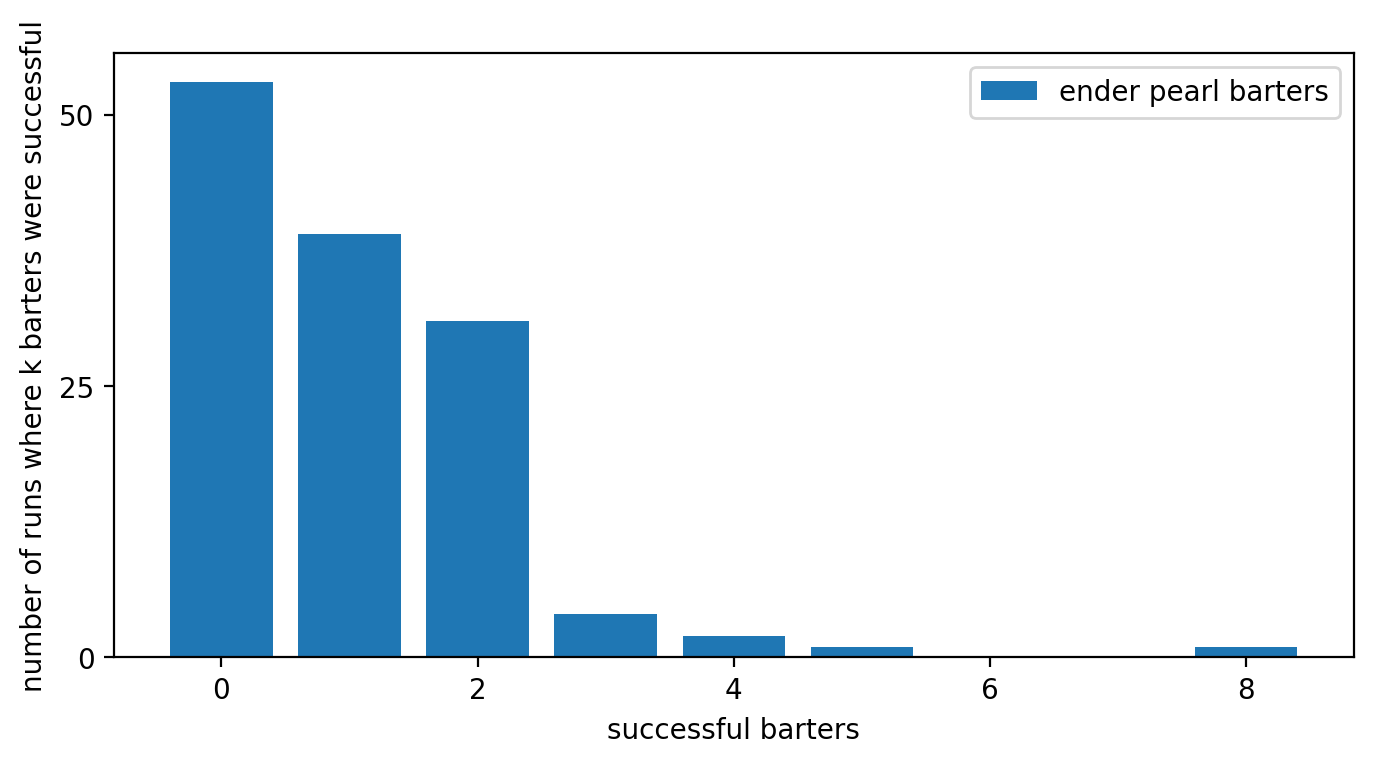

In [21]:
# the Ender pearl stats have slightly different names
pearl_players = ['benex','dream_before','dream_after','illumina','sizzler','vadikus007']

# create a blank dataframe to ensure the proper format
all_pearl_barters = pd.DataFrame( {'n':[], 'k':[]} )

# load in the data
for p in pearl_players:
    all_pearl_barters = all_pearl_barters.append( pd.read_csv(f'data/bartering.{p}.tsv',sep="\t") )

# pull out all the unique values
pearl_k = sorted( all_pearl_barters['k'].unique() )
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

plt.bar( pearl_k, [all_pearl_barters['k'][ all_pearl_barters['k'] == k ].count() for k in pearl_k], \
        label='ender pearl barters' )

plt.xlabel('successful barters')
plt.ylabel('number of runs where k barters were successful')
plt.yticks([0,25,50])

plt.legend()
plt.show()

Figure \ref{fig:ender_pearl_barter} provides further evidence that Ender pearl trades are more Binomial than Negative Binomial. The most common outcome is zero successful barters, which implies many speed runners quit when poor bartering luck cost them too much time. Piglins return anywhere from four to eight Ender pearls from a successful barter, and while I cannot find information on the distribution it is almost certainly uniform. This means one Ender pearl trade is enough to complete a speed run in theory, though that implies nailing the 20\% chance of getting the maximum number of Ender pearls on that barter, picking up two more from elsewhere, and performing the barely-feasible ten-Eye speedrun outlined previously. In contrast, two Ender pearl barters have a 60\% chance of giving twelve or more pearls, and as long as none of the resulting Eyes of Ender break while finding the Stronghold there's a 100\% chance the runner can immediately go to The End.

The rarity of three or more successful barters does suggest runners immediately moved on after achieving two barters, but it could also be true that some runners found themselves in the 40\% that had eleven or fewer pearls, tried bartering until they ran out of gold and failed to get a third barter, then gave up. The balance of evidence suggests Ender pearl barters mostly follow a Binomial distribution, which means we need to get a distribution for $n$ instead of $k$.

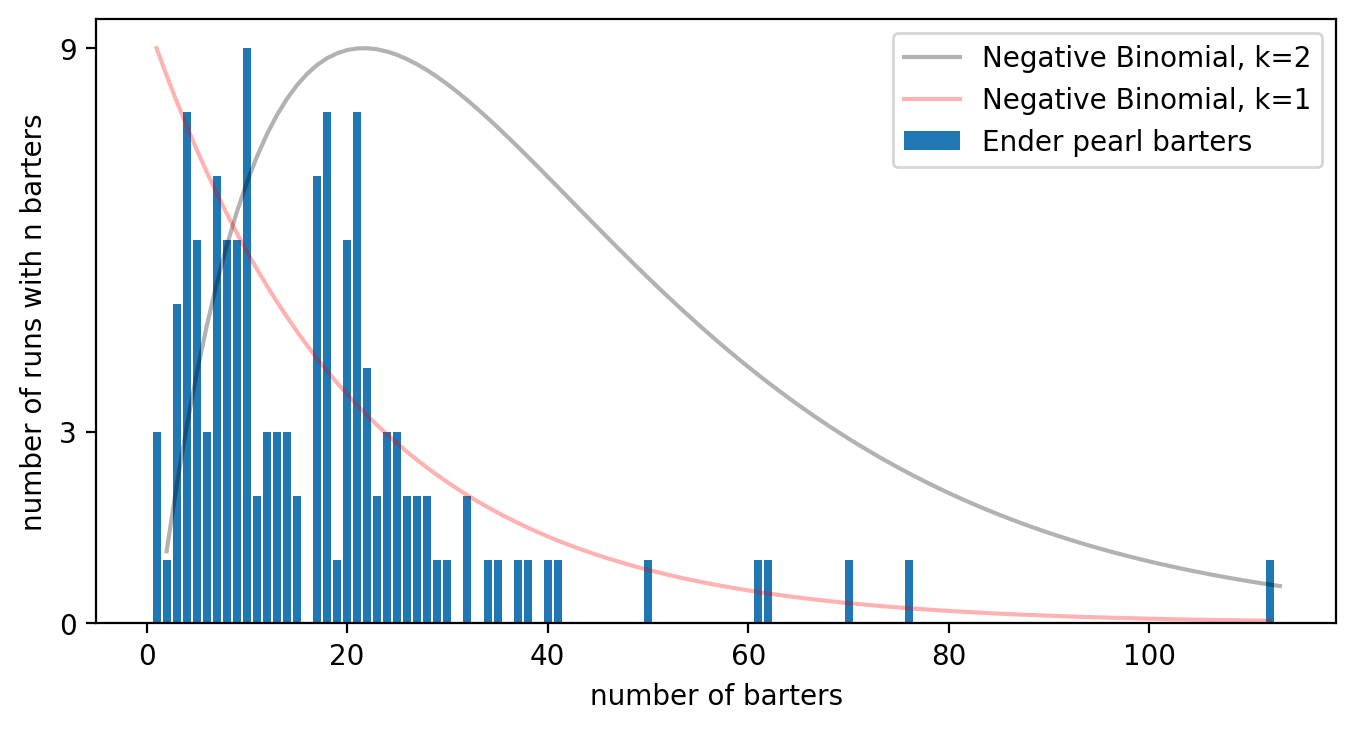

In [22]:
r_pearl = 20/423

# pull out all the unique values
pearl_n = sorted( all_pearl_barters['n'].unique() )
x       = np.arange(int(max( pearl_n )))

# separate these so we can scale the negative binomial appropriately
pearl_y   = [all_pearl_barters['n'][ all_pearl_barters['n'] == n ].count() for n in pearl_n]
nbinom2_y = nbinom( 2, r_pearl ).pmf( x )
nbinom1_y = nbinom( 1, r_pearl ).pmf( x )

nbinom2_y = nbinom2_y / np.max(nbinom2_y) * np.max(pearl_y)
nbinom1_y = nbinom1_y / np.max(nbinom1_y) * np.max(pearl_y)

fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

plt.bar( pearl_n, pearl_y, label='Ender pearl barters' )
plt.plot( x + 2, nbinom2_y, '-k', label='Negative Binomial, k=2', alpha=0.3 )
plt.plot( x + 1, nbinom1_y, '-r', label='Negative Binomial, k=1', alpha=0.3 )

plt.xlabel('number of barters')
plt.ylabel('number of runs with n barters')
plt.yticks([0,3,9])

plt.legend()
plt.show()

If Ender pearl barters followed a Negative Binomial, we'd expect the observed $n$ to follow a specific pattern. As Figure \ref{fig:ender_pearl_barter} shows, for the most part they do not. It's plausible that some of the data could be explained by a linear combination of the $k=1$ and $k=2$ cases, but the lack of barters at $10 < n < 17$ and $n > 25$ cannot. We'll use the observed distribution of $n < 55$ to generate values for $n$ and draw $k$ according to the appropriate probabilities. For the cheating case, we'll use $\frac 3 2 r_\text{fair} = \frac{30}{423}$.

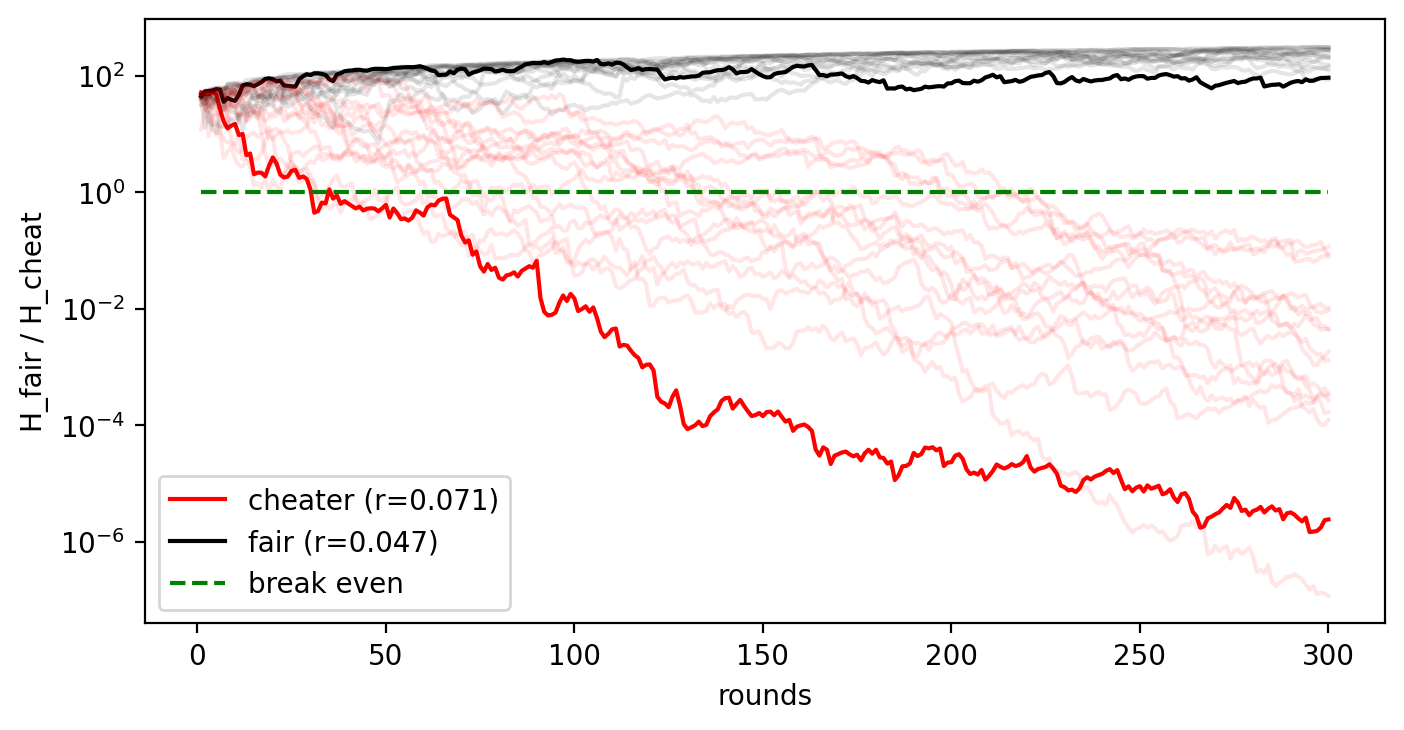

In [23]:
random  = np.random.default_rng(64)

r_fair    = r_pearl
r_cheat_h = r_pearl * 1.5
count     = 300
clones    = 16
a_prior, b_prior   = prior(r_fair, 4)

# build the distribution for n
mask    = all_pearl_barters['n'] < 55
pearl_n = sorted( all_pearl_barters['n'][mask].unique() )
weights = np.array([all_pearl_barters['n'][ all_pearl_barters['n'] == n ].count() for n in pearl_n])
pearl_s = np.sum( weights )
weights = weights / pearl_s

x      = np.arange(1, count+1)
n      = np.array(random.choice( pearl_n, size=(clones,count), p=weights ), dtype='int64')
sum_n  = np.cumsum( n, axis=1 )

cheat_h_k = np.cumsum( random.binomial( n, r_cheat_h ), axis=1 )
fair_k    = np.cumsum( random.binomial( n, r_fair ), axis=1 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

for idx in range(clones):
    y = [BF_H_fair_H_cheat(cheat_h_k[idx][i], sum_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-r', label=f'cheater (r={r_cheat_h:.3f})' )
    else:
        plt.plot( x, y, '-r', alpha=0.1 )

    y = [BF_H_fair_H_cheat(fair_k[idx][i], sum_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-k', label=f'fair (r={r_fair:.3f})' )
    else:
        plt.plot( x, y, '-k', alpha=0.1 )

plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:sim_pearl_trio} has the same general trends as Figure \ref{fig:sim_blaze_trio}. It is more reluctant to accumulate evidence for $H_\text{cheat}$, which matches intuition. It is difficult to determine the rate of rare events, and by extension it must be difficult to determine the rate of a rare event *not* occuring, otherwise we'd always calculate the latter instead of the former. Put mathematically, we'd expect the difficulty to be roughly proportional to $p(1-p)$, which has a maximum at $p = \frac 1 2 = r_\text{blaze}$. So despite $\frac{30}{423}:\frac{20}{423} > \frac{569}{500}$, the simulation behind Figure \ref{fig:sim_pearl_trio} had to add an extra hundred rounds to show a clean separation between the fair and cheating players. By luck, the highlighted players are outliers among their peers; still, the proposed Bayes factor performs well.

# Real-World Results

With all the above analysis in place, we can now look at real world data.

## Blaze Rod Drops

We will begin with the Blaze rod data. The MST report gathered data for five distinct Minecraft 1.16 speedrunners, Benex, Dream, Illumina, Sizzler, and Vadikus007.

In [37]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # makes colouring some of the following easier

blaze_rods = {p:pd.read_csv(f'data/blaze.{p}.tsv',sep="\t") for p in blaze_players}

blaze_rods['dream'].set_index('n').transpose()

n,12,11,16,10,13,11,5,4,1,14,...,9,10,15,10,15,11,9,10,9,9
k,6,7,8,7,8,8,5,3,1,8,...,8,6,8,7,7,7,7,7,7,8


We'll use the same chart as before, which shows how the Bayes factor changes as new data is added. This responds to a critique of the PE report: if the same trend is observed regardless of whether or not the last datapoint is dropped, we can be reasonably confident it was not an artifact of our stopping point.

As promised, we will determine how much influence the prior has by varying the scale parameter. My prefered value of 4 will be multiplied by both $\frac 1 3$ and 3, forming an "envelope" around it. The higher multiplier will "tug" the posterior towards the default hypothesis, while for better or worse the lower gives the data more power to shape the posterior.

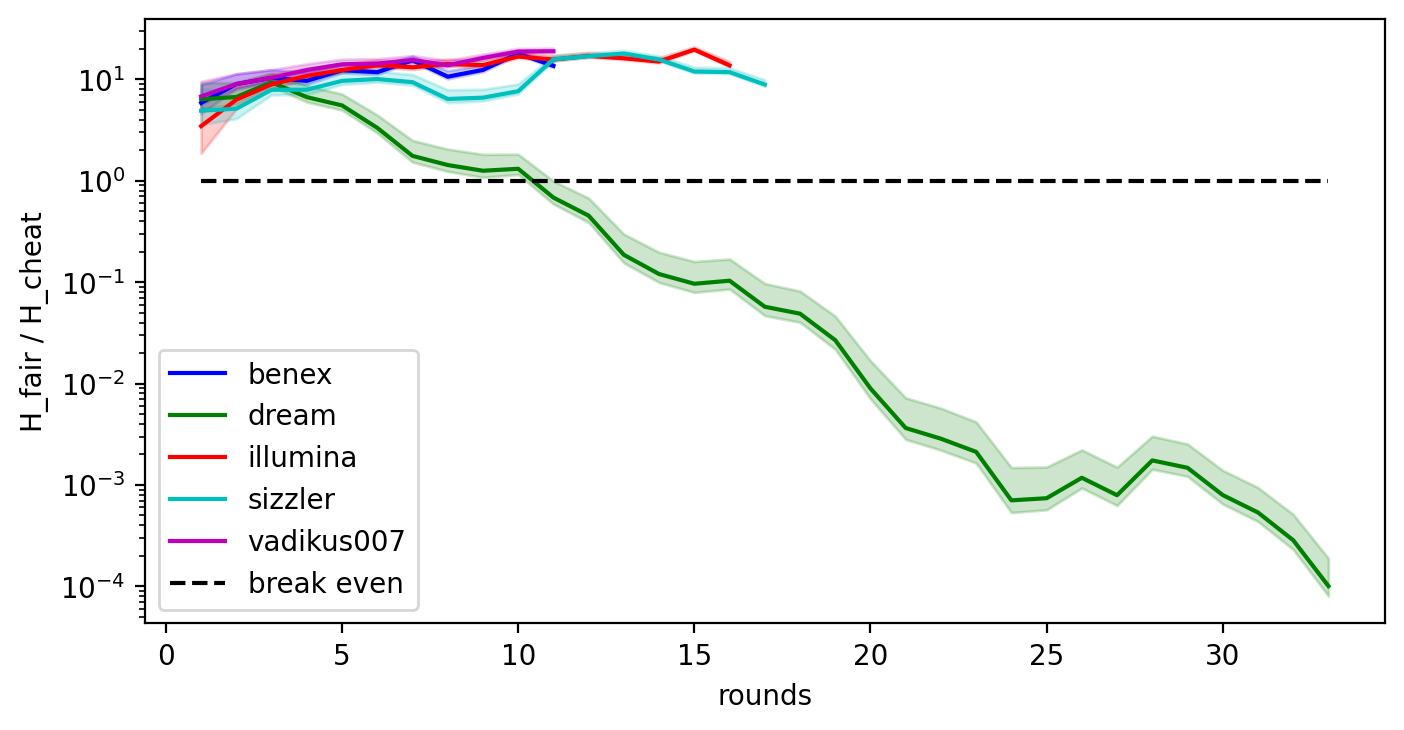

In [51]:
r_fair = Fraction(1,2)
priors = [prior( r_fair, scale ) for scale in [Fraction(4,3), 4, 12]]
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

max_count = 0

for i,p in enumerate(blaze_players):
    
    count = len(blaze_rods[p])
    if count > max_count:
        max_count = count
        
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( blaze_rods[p]['n'] )
    sum_k = np.cumsum( blaze_rods[p]['k'] )

    y = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[1]) for i in range(count)]
    plt.plot( x, y, '-', label=p, c=colours[i] )
    
    y_low = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[0]) for i in range(count)]
    y_hig = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[2]) for i in range(count)]
    plt.fill_between( x, [float(v) for v in y_low], [float(v) for v in y_hig], alpha=0.2, color=colours[i] )

x = range(1,max_count+1)
plt.plot( x, [1 for v in x], '--k', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:data_blaze} shows that the Bayes factor for Dream's Blaze rod drop rate behaves differently from other Minecraft speedrunners. It drops like the cheating players from Figure \ref{fig:sim_blaze_trio}, but at a much sharper rate. Removing the last datapoint would not remove that trend. There is evidence of some of the other runners curving back towards the 1:1 odds line, but that is consistent with random fluctuations due to normal gameplay. Altering the prior has little effect, though the log scaling can be deceptive; the Bayes factor for Dream's round 33 using the scale 4 prior is half the size of the BF for the scale 12 prior.

In [73]:
r_fair         = Fraction(1,2)
sum_n          = blaze_rods['dream']['n'].sum()
sum_k          = blaze_rods['dream']['k'].sum()
dream_blaze_bf = BF_H_fair_H_cheat( sum_k, sum_n, r_fair, *prior(r_fair,4) )

print( f"The Bayes factor for Dream's Blaze rod rate, over all his rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_blaze_bf,3)}, or about 1:{int(mp.fdiv(1,dream_blaze_bf)):,}." )

The Bayes Factor for Dream's Blaze rod rate, over all his rounds and with the scale 4 prior, is 0.000101, or about 1:9,930.


The resulting Bayes factor is roughly equivalent to the average golfer [landing a hole in one](https://www.pga.com/archive/odds-hole-in-one-albatross-condor) on their next shot. In comparison, the p-value for Dream's Blaze rod drop rate in the MST report is $4.72 \times 10^{-11}$, a difference of seven orders of magnitude, so on the surface it does seem true that Bayesian statistics is inherently more sluggish to respond to the data.

The PE report puts the probability of fair play at $3 \times 10^{-8},$ however. Why do two Bayesian analyses come to two very different results? The PE report analyzed Dream's drop rate by calculating a grid of probabilities ranging from $\frac 1 2$ to $\frac 9 {10}$, then taking the result for $r_\text{blaze} = \frac 1 2$ as the probability of fair play (pg. 10). This is analogous to the idealized dart board of a prior argument, which by necessity will lead to more extreme values. By integrating over an area, my definition of both $H_\text{fair}$ and $H_\text{cheat}$ account for the random fluctuations we would expect from random data, which necessarily waters down the probabilities of each. The PE report also does not factor in the probability of $H_\text{cheat}$. If that hypothesis is unlikely, then the relative likelihood of $H_\text{fair}$ is boosted proportionately.

Figure \ref{fig:data_blaze} only tells us the relative probabilities of $H_\text{fair}$ to $H_\text{cheat}$, unfortunately. It gives no indication of what the most credible drop rate is. For that, we need to chart the posteriers for each player. I'll show the results with the same range of prior scalings as Figure \ref{fig:data_blaze}.

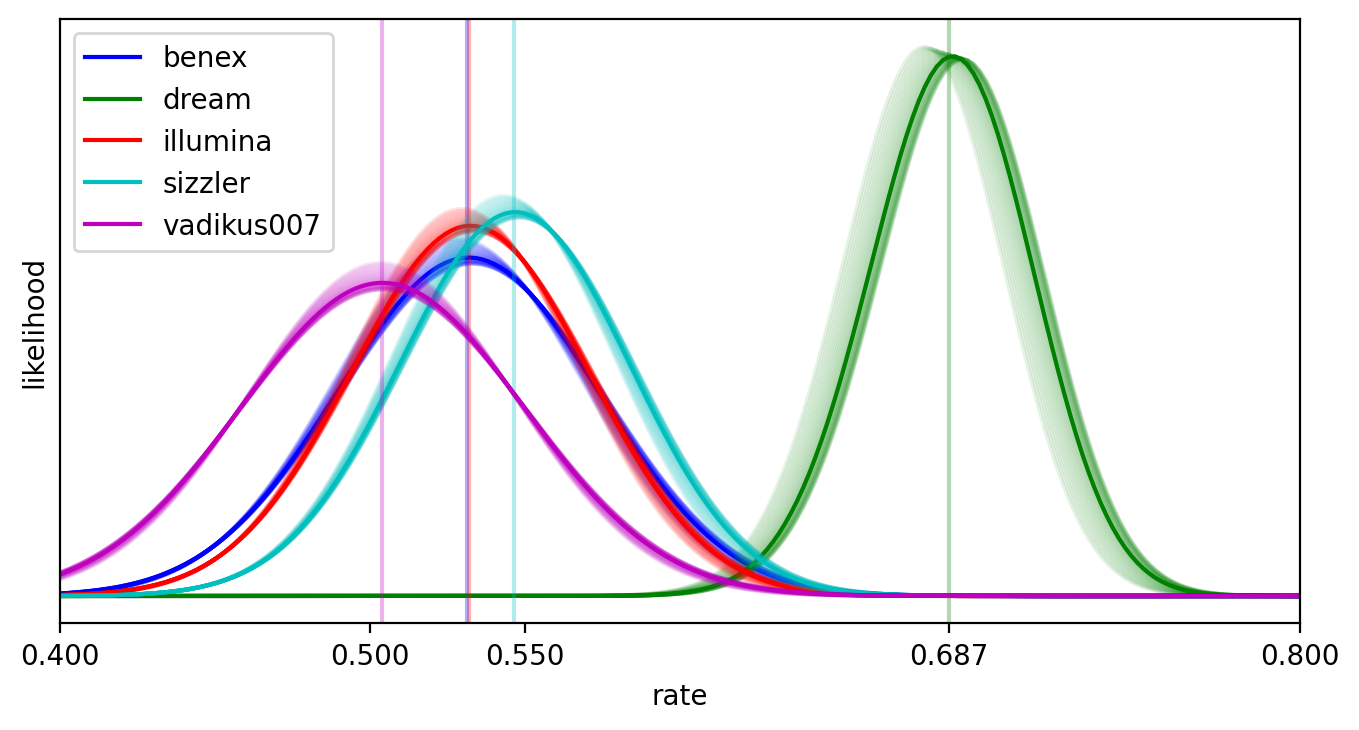

In [53]:
r_fair = Fraction(1,2)

fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

dream_mean = 0  # store Dream's mean value here

# fill_between doesn't give good output here. Instead, spam priors!
priors = [prior( r_fair, scale ) for scale in np.exp(np.linspace( np.log(4/3), np.log(12), 32 ))]
a_prior, b_prior = prior( r_fair, 4 )

x = np.linspace( 0, 1, 512 )
for i,p in enumerate(blaze_players):

    sum_n = np.sum( blaze_rods[p]['n'] )
    sum_k = np.sum( blaze_rods[p]['k'] )
    
    plt.plot( x, beta.pdf( x, float(a_prior + sum_k), float(b_prior + sum_n - sum_k) ), \
             '-', label=p, c=colours[i] )
    for pr in priors:
        plt.plot( x, beta.pdf( x, float(pr[0] + sum_k), float(pr[1] + sum_n - sum_k) ), \
             '-', alpha=0.1, c=colours[i] )

    plt.axvline( (a_prior + sum_k)/(a_prior + b_prior + sum_n), c=colours[i], alpha=0.3 )
    
    if p == 'dream':
        dream_mean = (a_prior + sum_k)/(a_prior + b_prior + sum_n)
    
plt.xlabel("rate")
plt.xlim( [.4,.8] )
plt.xticks( [.4, .5, .55, float(dream_mean), .8] )
plt.ylabel('likelihood')
plt.yticks([])

plt.legend()
plt.show()

According to Figure \ref{fig:data_blaze_pos}, the posterior distributions of other Minecraft players cluster on the generous side of 50:50 odds. Sizzler is the largest outlier, with the mean of his posterior approaching 55\%, but even for them a substantial amount of credence is present for $r_\text{blaze} \le \frac 1 2$. Dream again stands alone, with the posterior's mean drop rate above $\frac 2 3$ and almost no credence around $r_\text{blaze} \le \frac 1 2$. This is similar to what the PE report's estimate of "around 0.7" (pg. 10). Strengthening the prior clusters the credence more tightly around $r_\text{blaze} = \frac 1 2$, but there is sufficient data to make the effect subtle at best.

In [66]:
r_fair           = Fraction(1,2)
sum_n            = blaze_rods['dream']['n'].sum()
sum_k            = blaze_rods['dream']['k'].sum()
a_prior, b_prior = prior(r_fair,4)

intervals = beta.ppf( [.025, .16, .84, .975], float(a_prior + sum_k), float(b_prior + sum_n - sum_k) )

print( "Given the above data and prior, about two-thirds of our credence for Dream's Blaze rod rate\n" + \
      f"  is in the interval [{intervals[1]:.3f}, {intervals[2]:.3f}], while about 95% is between " + \
      f"[{intervals[0]:.3f}, {intervals[3]:.3f}]." )

Given the above data and prior, about two-thirds of our credence for Dream's Blaze rod rate
  is in the interval [0.661, 0.713], while about 95% is between [0.635, 0.737].


It's quite common to generate confidence or credible intervals around some parameter you're estimating. Those can reiterate some of the problems of p-values, such as what the interval means or what counts as extreme, but most of those are rendered moot via Bayesian statistics and the Beta function. There is no hard and fast rule on how much credence should be contained within the interval. The traditional value of 95\% can be sensitive to extreme data, so I prefer $\frac 2 3$. Code \ref{code:blaze_credible_int} has the results for both.

# Ender Pearl Barters

We have two sources of data for Ender pearls. The MST report collected bartering data for five runners including Dream, and Dream himself provided [a spreadsheet](https://drive.google.com/file/d/1EvxcvO4-guI73FH5pMUJ-zEHhV-L1yuJ/view) collecting additional statistics. Accessing that spreadsheet requires giving Dream or a third party my Google account information, so I instead opted to use the subset of data listed in Appendix A of the PE report. This second source carries the label "dream_before", as the streams it was collected from come before Dream took some time off of Minecraft 1.16 Random seed speed runs. The MST's data on Dream is labelled "dream_after", for similar reasons.

This provides us with an easy way to consider which, if any, of the above cheating scenarios apply.

1. If Dream cheated, and if he altered his barter rate from the start, we would expect the BF of both datasets to act like cheating players from the simulation and both posteriors to have little credence around $r_\text{blaze} = \frac{20}{423}$.
2. If Dream cheated, but only after he took some time off, we would expect the BF of the "before" set to behave like any other Minecraft speedrunner while the BF of the "after" acts like a cheating player. The posteriors would, respectively, cluster around $\frac{20}{423}$ and higher than it.
3. If Dream cheated, but craftily reduced his barter rate to hide it, we would expect the BF of both datasets to act like cheating players. The posteriors would, respectively, cluster below $\frac{20}{423}$ and above it.

Scenario 1 has already been ruled out by the PE report, as it notes the additional data reduces the probability of Dream cheating (pg. 13).

In [40]:
bartering  = {p:pd.read_csv(f'data/bartering.{p}.tsv',sep="\t") for p in pearl_players}
    
bartering['dream_after'].set_index('n').transpose()

n,22,5,24,18,4,1,7,12,26,8,...,2,13,10,10,21,20,10,3,18,3
k,3,2,2,2,0,1,2,5,3,2,...,0,1,2,2,2,2,2,1,2,2


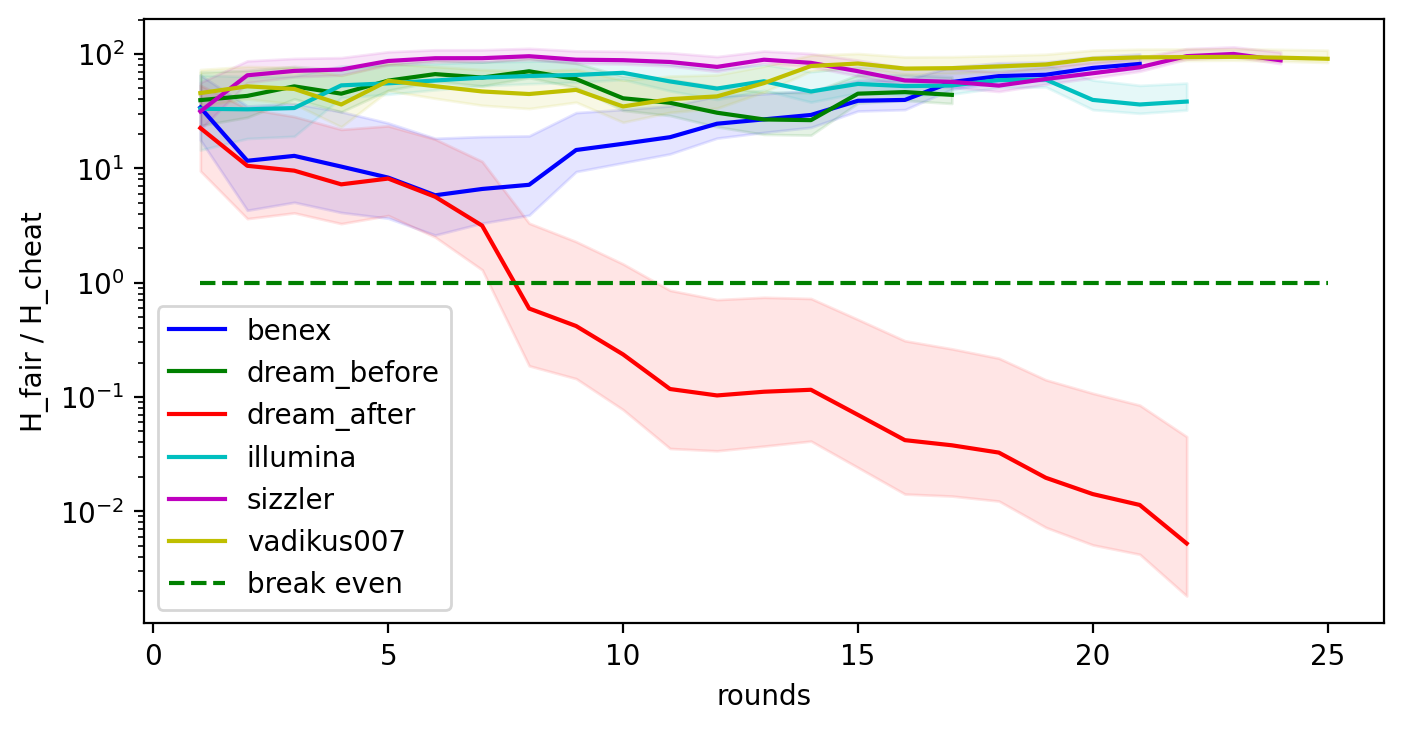

In [41]:
r_fair = Fraction(20,423)
priors = [prior( r_fair, scale ) for scale in [Fraction(4,3), 4, 12]]
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

max_count = 0

for i,p in enumerate(pearl_players):
    
    count = len(bartering[p])
    if count > max_count:
        max_count = count
        
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( bartering[p]['n'] )
    sum_k = np.cumsum( bartering[p]['k'] )

    y = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[1]) for i in range(count)]
    plt.plot( x, y, '-', label=p, c=colours[i] )
    
    y_low = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[0]) for i in range(count)]
    y_hig = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[2]) for i in range(count)]
    plt.fill_between( x, [float(v) for v in y_low], [float(v) for v in y_hig], alpha=0.1, color=colours[i] )

x = range(1,max_count+1)
plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:data_pearl} shows there's less certainty with this data. The same general pattern is present, with Dream's data after his break again behaving like the cheating player in the simulations. Other players and Dream's data before his break all behave more like fair players. Benex's first five rounds do show a downward trajectory, though this is compatible with a random good streak and their later data reverses the trajectory. This also suggests Scenario 3 is less likely than Scenario 2.

The choice of prior has a much stronger on the final outcome here than it did for Figure \ref{fig:data_blaze}, and the probabilities are about two orders of magnitude higher. The majority of this is due to the relative rarity of Ender pearl barters relative to Blaze rod drops, which waters down our credence for any given rate.

In [72]:
sum_n          = np.sum( bartering['dream_after']['n'] )
sum_k          = np.sum( bartering['dream_after']['k'] )
dream_pearl_bf = BF_H_fair_H_cheat( sum_k, sum_n, r_fair, *prior(r_fair,4) )

print( f"The Bayes factor for Dream's post-break Ender pearl barters, over all his rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_pearl_bf,3)}, or about 1:{int(mp.fdiv(1,dream_pearl_bf)):,}." )

The Bayes Factor for Dream's post-break Ender pearl barters, over all his rounds and with the scale 4 prior, is 0.00523, or about 1:191.


With my scale 4 prior, the relative odds between $H_\text{fair}$ and $H_\text{cheat}$ are about the odds of [a US citizen dying of an accidental poisoning](https://www.floridamuseum.ufl.edu/shark-attacks/odds/compare-risk/death/).  Alternatively, if you work two hundred days a year and on average take one sick day off per year, the Bayes factor is roughly equivalent to being too sick to work on your next shift. A rare occurance, certainly, but not that rare.

For comparison, the MST report put the p-value of this at $8.04 \times 10^{-7}$, which differs by five orders of magnitude. p-values are not probabilities, though, so there is no direct comparison between the two. The PE report gives the probability of fair play at $3 \times 10^{-10}$ (pg. 11), but that number uses the same methodology as the one for Blaze rods and so the same criticisms apply.

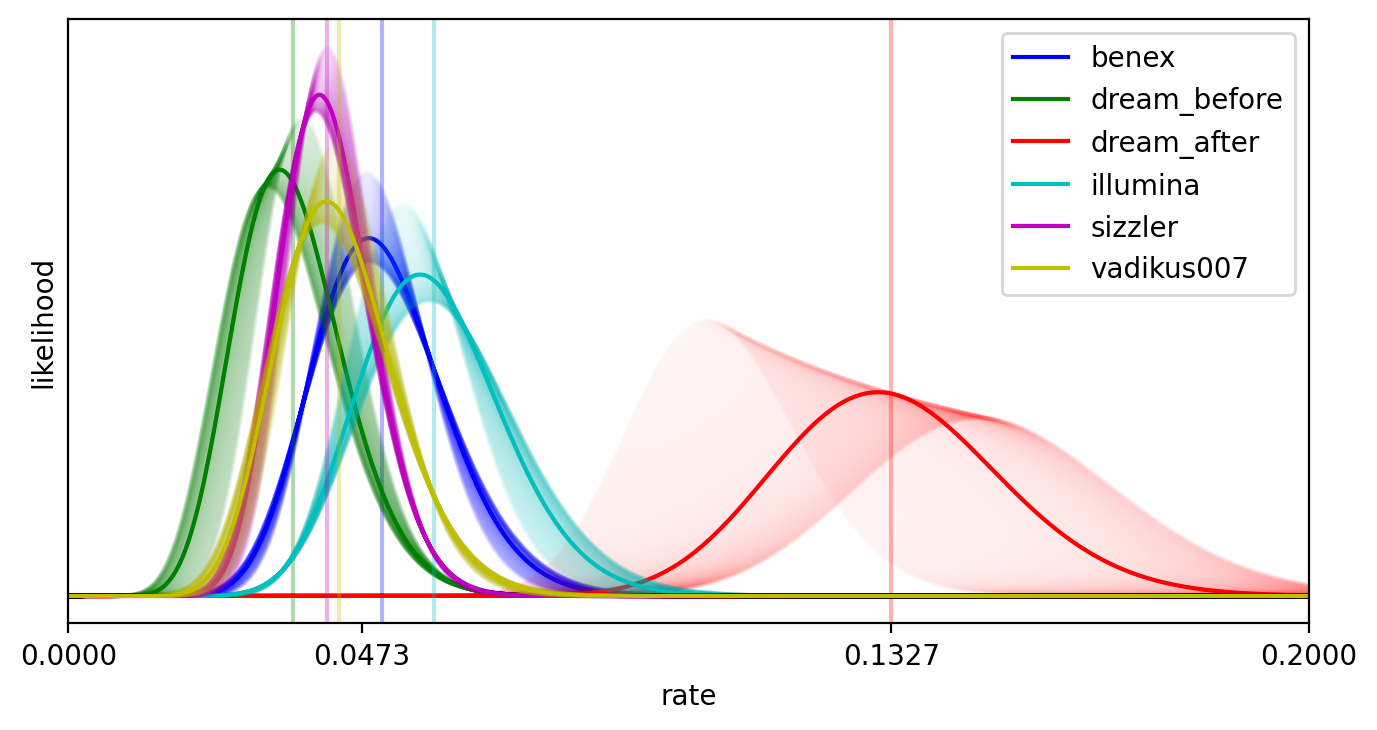

In [43]:
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

dream_mean = 0  # store Dream's mean value here
dream_means = list()

# fill_between doesn't give good output here. Instead, spam priors!
priors = [prior( r_fair, scale ) for scale in np.exp(np.linspace( np.log(4/3), np.log(12), 128 ))]
a_prior, b_prior = prior( r_fair, 4 )

x = np.linspace( 0, .2, 512 )
for i,p in enumerate(pearl_players):

    sum_n = np.sum( bartering[p]['n'] )
    sum_k = np.sum( bartering[p]['k'] )
    
    plt.plot( x, beta.pdf( x, float(a_prior + sum_k), float(b_prior + sum_n - sum_k) ), \
             '-', label=p, c=colours[i] )
    for pr in priors:
        plt.plot( x, beta.pdf( x, float(pr[0] + sum_k), float(pr[1] + sum_n - sum_k) ), \
             '-', alpha=0.03, c=colours[i] )
        if p == 'dream_after':
            dream_means.append( (pr[0] + sum_k) / (pr[0] + pr[1] + sum_n) )

    plt.axvline( (a_prior + sum_k)/(a_prior + b_prior + sum_n), c=colours[i], alpha=0.3 )
    
    if p == 'dream_after':
        dream_mean = (a_prior + sum_k)/(a_prior + b_prior + sum_n)
    
plt.xlabel("rate")
plt.xlim( [0,.2] )
plt.xticks( [0, float(r_fair), float(dream_mean), .2] )
plt.ylabel('likelihood')
plt.yticks([])

plt.legend()
plt.show()

Figure \ref{fig:data_pearl_pos} shows all but one dataset hovers around the expected rate of Ender pearl barters. The posterior for Dream's performance before his break favours lower barter rates than all other runners, providing a little support for Scenario 3, but note that a non-trivial amount of its credence is greater than the expected barter rate. Overall, Scenario 2 remains more likely even before we incorporate the Bayes factor values. 

Dream's post-break performance again is quite different from other speedrunners and even his own pre-break performance, but this time prior strength is a major factor. It should be noted that my prior for Ender pearl barters is fairly strong. My scale 4 prior for Blaze rod drops is mathematically equivalent to a Bayes/Laplace prior with six "phantom" observations added that precisely match the expected drop rate. The scale 4 prior for Ender pearl drops is equivalent to Bayes/Laplace with three successful Ender pearl drops observed and slightly more than 81 failed attempts. With so many phantom observations, much more data is necessary to overcome the latter prior's weight, and conversely small changes to that prior will lead to significant changes in the posterior. Nonetheless, I still think it is a good fit for my prior beliefs about Ender pearl drop rates, in both the cheating and fair cases.

The mean value of Dream's post-break performance is approximately three times larger than the expected rate, which again matches what the PE report observed (pg. 11).

In [67]:
r_fair           = Fraction(20,423)
sum_n            = bartering['dream_after']['n'].sum()
sum_k            = bartering['dream_after']['k'].sum()
a_prior, b_prior = prior(r_fair,4)

intervals = beta.ppf( [.025, .16, .84, .975], float(a_prior + sum_k), float(b_prior + sum_n - sum_k) )

print( "Given the above data and prior, about two-thirds of our credence for Dream's Ender pearl barter rate\n" + \
      f"  is in the interval [{intervals[1]:.3f}, {intervals[2]:.3f}], while about 95% is between " + \
      f"[{intervals[0]:.3f}, {intervals[3]:.3f}]." )

Given the above data and prior, about two-thirds of our credence for Dream's Ender pearl barter rate
  is in the interval [0.115, 0.151], while about 95% is between [0.099, 0.170].


Code \ref{code:pearl_credible_int} computes the credible intervals for Ender pearl bartering rates. A common heuristic is to see if the value we expect to see is contained within the interval, and invoke modus tollens if it is not. I do not endorse that, but if you disagree then I'll simply note that the bartering rate for an unadulterated copy of Minecraft 1.16.1 is not contained in either interval.

## Combining Both Datasets

As mentioned prior, Bayes factors are likelihoods and can thus be multiplied together. This allows us to generate a combined odds ratio for both datasets.

In [71]:
dream_combo_bf = mp.fmul( dream_blaze_bf, dream_pearl_bf )

print( f"The Bayes factor for both rates, over all of Dream's post-break rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_combo_bf,3)}, or about 1:{int(mp.fdiv(1,dream_combo_bf)):,}." )

The Bayes Factor for both rates, over all of Dream's post-break rounds and with the scale 4 prior, is 5.27e-7, or about 1:1,899,071.


The combined Bayes factor is quite low. To take an example, the median age of a Canadian in 2019 was [about 41 years old](https://www150.statcan.gc.ca/n1/daily-quotidien/190930/dq190930a-eng.htm). If we examine [the relevant mortuary tables](https://www150.statcan.gc.ca/n1/pub/84-537-x/2020001/xls/2017-2019_Tbl-eng.xlsx) and extrapolate the odds of dying per year to the odds of dying per day, then we'd place four times more credence on a specific 41-year-old Canadian woman dying within 24 hours (about 1:472,632) than we would for $H_\text{cheat}$ over $H_\text{fair}$.

As unlikely as that is, it's still seven orders of magnitude higher than the MST report's "loose upper bound" on Dream's success, which they declare is "almost certainly an overestimate" (pg. 22). After applying multiple corrections, the PE report concludes "there is a 1 in 100 million chance that a livestream in the Minecraft speedrunning community got as lucky this year on two separate random modes as Dream did in these six streams" (pg. 16), a number which is just about two order of magnitudes lower than what I calculate. The differences are entirely due to statistical methodology.

# Conclusion

I will refrain from stating conclusively that Dream boosted his Blaze rod drop and Ender pearl barter rate. To explain why, it is worth discussing stopping rules.

## Stopping Rules

Both the MST and PE reports invoke stopping rules, though in a way that is not congruent with how they are used within the scientific community.

> Suppose that a researcher is testing whether one variable influences another or is comparing two treatments
or effect sizes. Suppose also that the researcher is primarily interested in whether there is an effect (or difference) and, if so, the direction of the effect. Finally, suppose that the researcher wants to set alpha at .05, which is to say, have a 5% probability of rejecting the null hypothesis of no effect, if it is true.\footnote{As I said earlier, even professionals misunderstand p-values on a regular basis.} 

> Dsing the fixed-sample stopping rule, the researcher would determine the number of subjects to be tested prior to performing the study. However, there is another type of stopping rule, called sequential stopping rules, which was first proposed by Wald in 1947. In a sequential stopping rule, the outcome ofthe statistical test could lead to testing more subjects. Thus, the number of subjects to be tested is not fixed in advance.\cite{frick_better_1998}

> According to Wainer (2000) an adaptive test can be considered complete after a predetermined number of items have been administered, when a predetermined level of measurement precision has been reached, or when a predetermined length of time has elapsed. The two most commonly used methods for determining when a computerized adaptive test is complete are the fixed length and variable length stopping rules.

> Under a fixed length stopping rule, an adaptive test is terminated when a predetermined number of items have been administered. Accordingly, all examinees are administered the same number of items, regardless of the degree of measurement precision achieved upon termination of the test. \[...\]

> In contrast, variable length stopping rules typically seek to achieve a certain degree of measurement precision for all examinees, even when doing so means that some examinees are given more items than others. Two types of variable length stopping rules have been used (Dodd, Koch, & De Ayala, 1993). These are the standard error (SE) stopping rule and the minimum information stopping rule. Of these, the most commonly used has been the SE stopping rule, which terminates an adaptive test when a predetermined standard error has been reached for the most recent examinee trait estimate (Boyd, Dodd, & Choi, 2010).\cite{choi_new_2010}

> One criticism of rules like O'Brien and Fleming is their rigidity in requiring a fixed maximum number of preplanned interim analyses. Greater flexibility is possible with the Peto-Haybittle rule, which simply specifies a fixed p value (often $p<0-001$) for stopping early. For example, the European myocardial infarction amiodarone trial (EMIAT) is an ongoing study of 1500 patients at high risk after myocardial infarction comparing amiodarone (an antiarrhythmic drug) with placebo. Two year mortality is the primary end point, and the stopping guideline for efficacy is $p < 0.001$ in favour of amiodarone.\cite{pocock_when_1992}

A clear stopping rule is necessary when the number of datapoints you could look at is practically infinite; we could survey every single person in the United States to determine their political views, but it is more feasible to pick a large enough sample of them to achieve a certain statistical accuracy. Alternatively, we could flip between data gathering and analysis until our target accuracy or statistical measure is reached, but this risks coming to a premature stop due to statistical fluctuations; had we just analyzed X more datapoints, our test statistic would switch from "statistically significant" to "not statistically significant" and our declaration of significance would be premature.

Dream has not completed a practically infinite number of Minecraft 1.16 Random Seed Any \% runs, however. If our hypothesis is that Dream boosted his drop/barter rate since returning to that speedrun category, then the entire dataset consists of thirty-three runs where Blazes were killed for Blaze rods, and twenty-two runs where Ender pearls were bartered for, spread across six streaming sessions. There is no more data to be collected, and the data that is present is nowhere near large enough to pose an analytic challenge. If those datapoints were insufficient to establish the hypothesis, then a well-designed statistical test metric will conclude the evidence is inconclusive. If the fluctuations could be due to chance, then a well-designed metric will take that into account. The data cannot be cherry-picked to artificially boost the metric, as the MST report examines every applicable cherry.

The imposition of a binary decision threshold on continuous test statistics, and the resulting necessity of stopping rules, has led some researchers have called for the abandonment of statistical significance entirely.\cite{doi:10.1080/00031305.2018.1527253} Rather than have the researcher or publisher check if p-values or Bayes factors cross a certain threshold, they propose researchers and publishers take a holistic approach that also factors in "related prior evidence, plausibility of mechanism, study design and data quality, real world costs and benefits," and "novelty of finding" among other things.

As an outsider to the Minecraft speedrunning community, I do not have full knowledge of prior evidence. I do not have a good understanding of the costs or benefits of removing Dream's speed-running records, and should I make the wrong decision I will not pay the consequences. The best thing I can do is to instead lay out my full reasoning as clearly I can. If the community accepts the premises behind my arguements and can find few flaws in how I link them together, they are in a much better position to decide the best course of action.

# Future Work

While I cannot provide a solid yes or no, I have provided several things which may prove useful. My analysis above is applicable to any Bernoulli process where we do not know the true rate. If we have a hypothesis that the rate is a specific value, and no strong alternative hypothesis, then the two Python routines `posterior_H_fair()` and `BF_H_fair_H_cheat()` can be invoked to generate a Bayes factor for that hypothesis relative to another pseudo-inverse hypothesis. Both routines run quite fast; most of this notebook was developed on an [Asus Transformer](https://en.wikipedia.org/wiki/Asus_Transformer#Asus_Transformer_Book), and the slowest cell takes about thirty seconds to execute. Both routines are also quite flexible, as they allow arbitrary Beta priors to be supplied and use arbitrary precision to ensure math overflow isn't a problem. This makes those routines applicable well beyond the simple question of "did Dream cheat?"

I have also tried to make it as easy as possible to build another analysis on top of this one. If, for instance, you do not agree with my definition of $H_\text{cheat}$, you can develop your own mathematical version and use that to weight the posterior. Just as I tried to take the best parts of the MST and PE reports to build a new analysis, you could do the same with this report. 

For instance, one idea not explored here is heirarchical models. The PE report attempted to build such a model for Ender pearl barters using Monte Carlo simulations, but a better approach is to invoke [Stan](https://mc-stan.org/users/documentation/case-studies/radon.html) or [emcee](https://emcee.readthedocs.io/en/stable/tutorials/line/) to build and sample from the posterior. This would allow you to test the success rate of barters, the number of Ender pearls dropped per successful barter, and the amount of gold a speedrunner could gather simultaneously. Rather than assert whether the speedrunner's goal was ten or twelve Ender pearls, as the PE report's simulation does, they can be free parameters in the model that the MCMC engine will explore for you.

At minimum, I at least hope to have provided a different and more rigorous approach towards analyzing whether or not a speedrunner modified their game.